<a id="top"></a>
## Table of Contents
* [0. Project Description](#0)
* [1. Libraries](#1)
* [2. Data Collection](#2)
    - [2.1 Data Loader](#2.1)
    - [2.2 An Overview of the Data](#2.2)
* [3. Exploratory Data Analysis](#3) 
    - [3.1 Statistics](#3.1)
        - [3.1.1 Distribution of Labels](#3.1.1)
        - [3.1.2 Distribution of Document Lengths](#3.1.2)
        - [3.1.3 Overlab between query and title](#3.1.3)
    - [3.2 Summary of EDA and Futer steps](#3.2)
* [4. Data Module](#4)
    - [4.1 Pre-processing](#4.1)
        - [4.1.1 Flitering out the Outliers](#4.1.1)
        - [4.1.2 Upsampling of the training data via LLMs](#4.1.2)
    - [4.2 Overview of the New Dataset](#4.2)
* [5. Model Module](#5)
* [6. Results](#6)
* [7. Conclusion & Future Development](#7)

The source code and basic project setup are available at https://github.com/lijunfeng99/CS5242-project_25

##  0. <a name='0'></a>Project Description
[Back to Table of Contents](#top)

### Exploring Language Models for Query-Document Relevance Prediction on the QBQTC Dataset

In this project, we aim to explore the effectiveness of various deep learning-based language models in predicting query-document relevance using the QBQTC dataset. Specifically, we will experiment with three prominent architectures: Recurrent Neural Networks (RNN), Transformer models, and BERT (Bidirectional Encoder Representations from Transformers).

The QBQTC (QQ Browser Query Title Corpus) dataset is a large-scale Learning to Rank (LTR) dataset developed by the QQ Browser search engine team. It is designed for general web search scenarios and incorporates multi-dimensional annotations, including relevance, authority, content quality, and timeliness. For this project, we focus on the relevance labels, which indicate how well a given document title matches a user query:

- 0: Poor relevance
- 1: Moderately relevant
- 2: Highly relevant

The dataset is split into the following subsets:

Training set: 180,000 samples
Development set: 20,000 samples
Public test set: 5,000 samples
Our goal is to build and compare models that can effectively predict the relevance score between a query and a document title. The performance of each model will be evaluated on the development and test sets using appropriate ranking and classification metrics.

Through this project, we aim to understand the relative strengths and limitations of different neural language model architectures in the context of information retrieval and learning to rank tasks.

##  1. <a name='1'></a>Libraries
[Back to Table of Contents](#top)

In [ ]:
%matplotlib inline
import os
import sys
import math
import time
import json
import copy
import random
import collections
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_inline import backend_inline
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm.auto import tqdm as tqdm_auto
import jieba
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import ollama
from IPython import display

sys.path.append("/content/drive/MyDrive/CS5242/")


##  2. <a name='2'></a>Data Collection
[Back to Table of Contents](#top)

For data collection, we first collected about 6000 reviews data for the first time. However, after data analysis, we found that the distribution and proportion of the data were seriously uneven.The main problem is that the negative and neutral data are seriously insufficient, and the second is that the data of some aspects is also seriously insufficient. So we scoured multiple websites, controlling the data tags for each crawl, and finally got our current dataset.

###  2.1 <a name='2.1'></a> Data Loader

To prepare the QBQTC dataset for model training and evaluation, we implemented a custom data loader in Python to handle the JSON-formatted data files. The dataset is stored in three separate files: `train.json`, `dev.json`, and `test.json`, located in the `./dataset/` directory.

We defined a function read_json_file to read each file line by line and parse each line as a JSON object. This approach ensures robustness against potential formatting issues, as it skips any lines that cannot be properly parsed.

In [2]:
dataset_path = './dataset/'

def read_json_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                item = json.loads(line.strip())
                data.append(item)
            except json.JSONDecodeError:
                print(f"Error parsing line: {line}")
    return data

files = ['train.json', 'dev.json', 'test.json']
data_dict = {}

for file in files:
    file_path = os.path.join(dataset_path, file)
    if os.path.exists(file_path):
        data = read_json_file(file_path)
        data_dict[file.split('.')[0]] = data
        print(f"read {file}，include {len(data)} ")

train_df = pd.DataFrame(data_dict['train'])
dev_df = pd.DataFrame(data_dict['dev'])
test_df = pd.DataFrame(data_dict['test'])
print(train_df.head())
print(dev_df.head())
print(test_df.head())


read train.json，include 180000 
read dev.json，include 20000 
read test.json，include 5000 
   id            query                           title label
0   0            应届生实习                    实习生招聘-应届生求职网     1
1   1  ln1+x-ln1+y=x-y  已知函数fx=1lnx+1-x则y=fx的图像高考吧百度贴吧     0
2   2         大秦之悍卒189                   起点中文网阅文集团旗下网站     0
3   3             出门经咒                     快快乐乐出门咒-豆丁网     1
4   4           盖中盖广告词              谁知道盖中盖所有的广告词急用百度知道     1
   id             query                                              title  \
0   0            小孩咳嗽感冒                              小孩感冒过后久咳嗽该吃什么药育儿问答宝宝树   
1   1      前列腺癌根治术后能活多久                    前列腺癌转移能活多久前列腺癌治疗方法盘点-家庭医生在线肿瘤频道   
2   2          英雄大作战022               英雄大作战v0.65无敌版英雄大作战v0.65无敌版小游戏4399小游戏   
3   3  如何将一个文件复制到另一个文件里                           怎么把布局里的图纸复制到另外一个文件中去百度文库   
4   4        gilneasart  gilneas-pictures&charactersart-worldofwarcraft...   

  label  
0     1  
1     1  
2     1  
3     0  
4     1  
      id       

###  2.2 <a name='2.2'></a> An Overview of the Data

In [3]:

# merge all data into one dataframe
records = []
for name, data in data_dict.items():
    records.extend(data)
df = pd.DataFrame.from_records(records)
df["label"] = df["label"].astype(int)

print(f'#texts: {len(df)}')
print(df.info())
df.head()

#texts: 205000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205000 entries, 0 to 204999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      205000 non-null  int64 
 1   query   205000 non-null  object
 2   title   205000 non-null  object
 3   label   205000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.3+ MB
None


,id,query,title,label
0,0,应届生实习,实习生招聘-应届生求职网,1
1,1,ln1+x-ln1+y=x-y,已知函数fx=1lnx+1-x则y=fx的图像高考吧百度贴吧,0
2,2,大秦之悍卒189,起点中文网阅文集团旗下网站,0
3,3,出门经咒,快快乐乐出门咒-豆丁网,1
4,4,盖中盖广告词,谁知道盖中盖所有的广告词急用百度知道,1


##  3. <a name='3'></a>Exploratory Data Analysis
[Back to Table of Contents](#top)

###  3.1 <a name='3.1'></a> Statistics

#### 3.1.1 Distribution of Labels
According to the distribution of Labels in the dataset, we can see that the dataset is imbalanced. The number of *Lable1* is much larger than the number of *Label0*. This will lead to a bias in the model training. We need to handle this issue by using techniques such as oversampling or undersampling.

<Axes: xlabel='label', ylabel='count'>

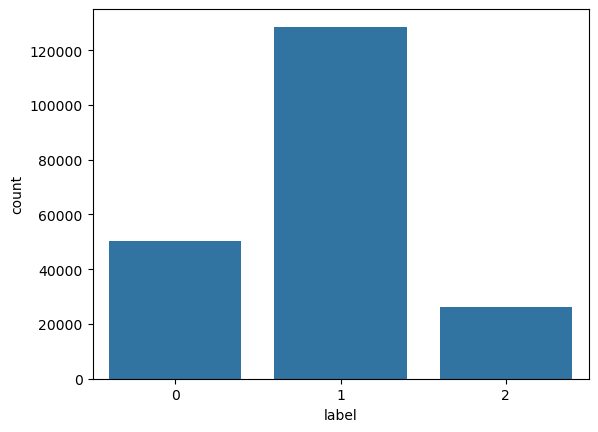

In [4]:
sns.countplot(x='label', data=df)

#### 3.1.2 Distribution of Document Lengths

EDA shows that query lengths are relatively short, averaging around 9.6 words, while titles are longer with a mean of 25.4 words. Both distributions have long tails, with maximum lengths of 246 for queries and 165 for titles, indicating some extreme outliers. The majority of queries fall between 6 and 11 words, and most titles between 15 and 31 words.

For preprocessing, consider capping overly long inputs and truncating or padding as needed for model input consistency. 

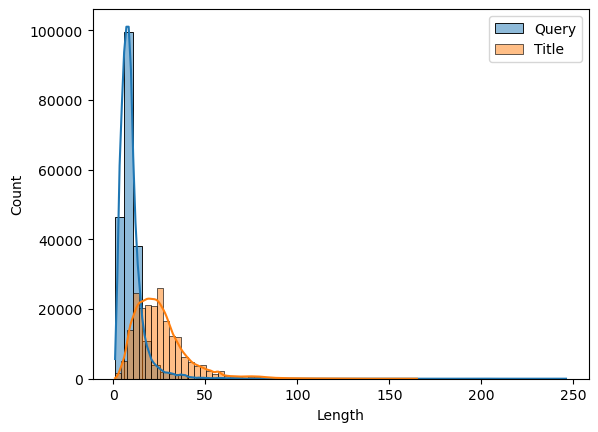

Query length description: count    205000.000000
mean          9.599380
std           7.293327
min           1.000000
25%           6.000000
50%           8.000000
75%          11.000000
max         246.000000
Name: query_len, dtype: float64
Title length description: count    205000.000000
mean         25.418395
std          14.729485
min           1.000000
25%          15.000000
50%          23.000000
75%          31.000000
max         165.000000
Name: title_len, dtype: float64


In [5]:
df['query_len'] = df['query'].apply(len)
df['title_len'] = df['title'].apply(len)

sns.histplot(df['query_len'], bins=50, kde=True, legend=True, label="Query")
sns.histplot(df['title_len'], bins=50, kde=True, legend=True, label="Title")
plt.legend()
plt.xlabel("Length")
plt.show()

print(f"Query length description: {df['query_len'].describe()}")
print(f"Title length description: {df['title_len'].describe()}")


#### 3.1.3 Overlap between query and title

To measure the textual similarity between queries and titles, we calculated the Jaccard similarity at the word level using Chinese word segmentation (jieba). The overall distribution of Jaccard similarity shows a relatively wide spread, indicating varying degrees of lexical overlap across samples.

When visualizing the similarity distributions by relevance labels, we observed no strong or consistent patterns. While higher relevance scores (label 2) tend to have slightly higher average similarity, the distributions of all three labels (0, 1, 2) overlap significantly. This suggests that simple word-level overlap is not a reliable standalone indicator of semantic relevance. In other words, queries and titles can be relevant even with low lexical overlap, possibly due to paraphrasing, synonym usage, or implicit relationships that word-level comparison fails to capture.ç.

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/mg/t_zxv0bx41x3ty06pvsqh1280000gn/T/jieba.cache
Loading model cost 0.370 seconds.
Prefix dict has been built successfully.


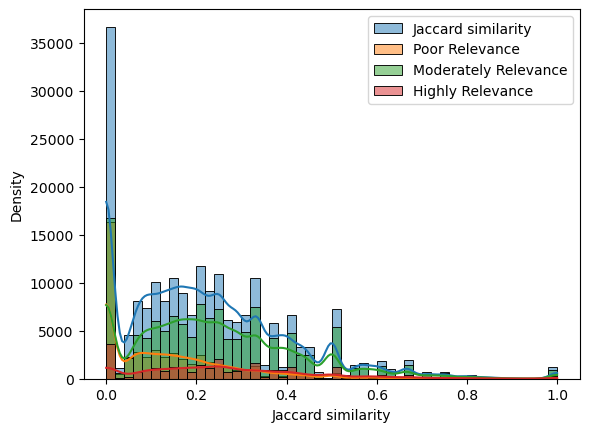

In [6]:
def calc_Jaccard(row):
    query_words = set(jieba.lcut(row['query']))
    title_words = set(jieba.lcut(row['title']))
    return len(query_words & title_words) / len(query_words | title_words)
df["Jaccard_similarity"] = df.apply(calc_Jaccard, axis=1)

sns.histplot(df['Jaccard_similarity'], bins=50, kde=True, legend=True, label='Jaccard similarity')
sns.histplot(
    df[df['label'] == 0]['Jaccard_similarity'],
    bins=50,
    kde=True,
    legend=True,
    label='Poor Relevance'
)
sns.histplot(
    df[df['label'] == 1]['Jaccard_similarity'],
    bins=50,
    kde=True,
    legend=True,
    label='Moderately Relevance'
)
sns.histplot(
    df[df['label'] == 2]['Jaccard_similarity'],
    bins=50,
    kde=True,
    legend=True,
    label='Highly Relevance'
)
plt.xlabel('Jaccard similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

### 3.2  <a name='3.2'></a> Summary of EDA and Futher steps
#### Summary:
- The dataset is **label-imbalanced**.
- **Queries are short** (~9.6 words), while **titles are longer** (~25.4 words), with a few extreme outliers.
- **Jaccard similarity** shows weak correlation with relevance, indicating that **lexical overlap is not enough** to capture semantic relevance.

#### Next Steps:
- Address **label imbalance** using resampling or class-weighted loss.
- Apply **padding/truncation** to standardize input lengths.

##  4. <a name='4'></a>Data Module
[Back to Table of Contents](#top)

##  4.1 <a name='4.1'></a>Pre-processing

###  4.1.1 <a name='4.1.1'></a> Filtering out the Outliers

According to our EDA results, we identified extreme outliers in both query and title lengths. Extremely long texts may not only increase computational cost but also lead to noise in training, as they may not represent typical search engine queries or titles.

To mitigate this, we filtered out entries where:
- The **query length** exceeds 30 characters.
- The **title length** exceeds 50 characters.

In [9]:
def filterout_length(data, max_len, column='text'):
    filtered_data = []
    for d in data:
        if len(d[column]) <= max_len:
            filtered_data.append(d)
    return filtered_data

for name, data in data_dict.items():
    data_dict[name] = filterout_length(data, 50, 'title')
    data_dict[name] = filterout_length(data_dict[name], 30, 'query')


###  4.1.2 <a name='4.1.2'></a> Sampling of the training data via LLMs
To balance the dataset, we use follow steps:

1. Drop 50% of the data with *Lable1*;
2. Use the LLM to rephrase all the data with *Label2* and add this sample to dataset.

This both balances the class distribution and increases dataset diversity through LLM-generated paraphrases.

In [8]:
def chat_with_ollama(sentence):
    client = ollama.Client()

    model_name = "mistral"

    response = client.chat(model=model_name, messages=[
        {"role": "user", "content": f"""Please rephrase this sentence:{sentence}"""}
    ],
    options={
        "num_predict": 15  # This is the equivalent of max_tokens in Ollama
    })

    return response['message']['content']

newdata_dict = {}
for name, data in data_dict.items():
    newdata_dict[name] = []
    id = 0
    for item in tqdm(data):
        id += 1
        item['id'] = id
        if item['label'] == '1':
            if random.random() < 0.5:
                newdata_dict[name].append(item)
        elif item['label'] == '2':
            newdata_dict[name].append(item)
            id += 1
            newdata_dict[name].append({
                "id": id,
                "query": chat_with_ollama(item['query']),
                "label": "2",
                "title": item['title'],
            })
        else:
            newdata_dict[name].append(item)

# save new data
for name, data in newdata_dict.items():
    with open(os.path.join(dataset_path, f"{name}_new.json"), "w") as f:
        json.dump(data, f, indent=4)
                

  0%|          | 0/167097 [00:00<?, ?it/s]

  0%|          | 0/18597 [00:00<?, ?it/s]

  0%|          | 0/4654 [00:00<?, ?it/s]

## 4.2 <a name='4.2'></a> Overview of the New Dataset

After comprehensive preprocessing, we finalized a clean and balanced dataset containing 154,592 samples. Each entry includes a query, a corresponding document title, and a relevance label (0–2). The dataset has been filtered to remove outlier lengths, with queries capped at 30 characters (mean ≈ 10.1) and titles at 50 (mean ≈ 22.8). Label imbalance was addressed via downsampling and LLM-based augmentation, resulting in a semantically diverse and model-ready corpus for training relevance models.


#texts: 154592
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154592 entries, 0 to 154591
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      154592 non-null  int64 
 1   query   154592 non-null  object
 2   title   154592 non-null  object
 3   label   154592 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.7+ MB
None


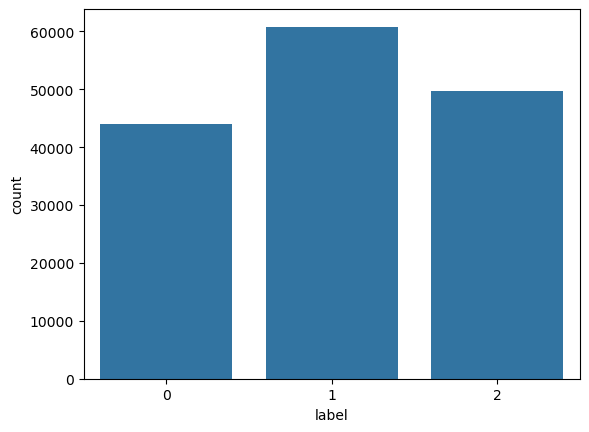

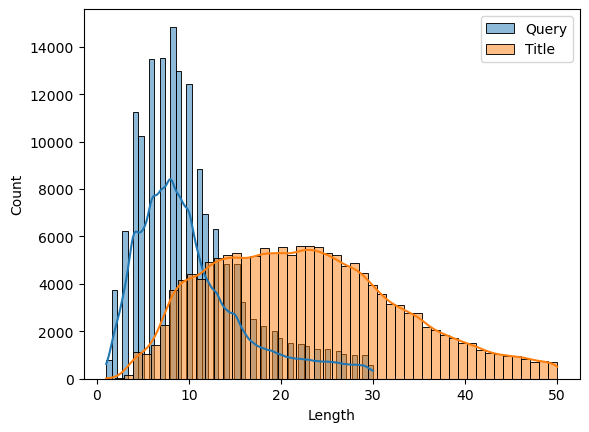

Query length description: count    154592.000000
mean         10.086563
std           5.892387
min           1.000000
25%           6.000000
50%           9.000000
75%          13.000000
max          30.000000
Name: query_len, dtype: float64
Title length description: count    154592.000000
mean         22.766631
std          10.286630
min           1.000000
25%          15.000000
50%          22.000000
75%          29.000000
max          50.000000
Name: title_len, dtype: float64


In [14]:
files = ['train_new.json', 'dev_new.json', 'test_new.json']
data_dict = {}

for file in files:
    file_path = os.path.join(dataset_path, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict[file] = json.load(f)

records = []
for name, data in data_dict.items():
    records.extend(data)
df = pd.DataFrame.from_records(records)
df["label"] = df["label"].astype(int)

print(f'#texts: {len(df)}')
print(df.info())
df.head()

sns.countplot(x='label', data=df)
plt.show()

df['query_len'] = df['query'].apply(len)
df['title_len'] = df['title'].apply(len)

sns.histplot(df['query_len'], bins=50, kde=True, legend=True, label="Query")
sns.histplot(df['title_len'], bins=50, kde=True, legend=True, label="Title")
plt.legend()
plt.xlabel("Length")
plt.show()

print(f"Query length description: {df['query_len'].describe()}")
print(f"Title length description: {df['title_len'].describe()}")

##  5. <a name='5'></a>Model Module
[Back to Table of Contents](#top)

###  5.1 <a name='5.2'></a>MLP
[Back to Table of Contents](#top)

![MLP Model Structure](img/mlp.jpg)

The MLP model described consists of an embedding layer that transforms input tokens into dense vectors, followed by multiple fully-connected hidden layers with ReLU activations to learn nonlinear patterns, and concludes with an output layer that produces logits for classification.

Dataset Loading

In [ ]:
data_path = "/content/drive/MyDrive/CS5242/dataset/"

def load_data(file):
    with open(data_path + file, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

train_df = load_data('train.json')
dev_df = load_data('dev.json')
test_public_df = load_data('test_public.json')

Building Vocab and Embedding Matrix


In [ ]:
def build_vocab(sentences, max_vocab_size=10000):
    counter = Counter()
    for sent in sentences:
        counter.update(sent.split())
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, _ in counter.most_common(max_vocab_size - len(vocab)):
        vocab[word] = len(vocab)
    return vocab

all_sentences = pd.concat([train_df, dev_df])['query'] + " " + pd.concat([train_df, dev_df])['title']
vocab = build_vocab(all_sentences)

embedding_dim = 100
embedding_matrix = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim)).astype(np.float32)

Text Encoding and Label Preparation


In [ ]:
def encode_text(df, vocab):
    encoded = [
        torch.tensor([vocab.get(w, vocab['<unk>']) for w in (q + " " + t).split()])
        for q, t in zip(df['query'], df['title'])
    ]
    return pad_sequence(encoded, batch_first=True, padding_value=0)

X_train_ids = encode_text(train_df, vocab)
y_train = torch.tensor(train_df['label'].astype(int).values)

X_dev_ids = encode_text(dev_df, vocab)
y_dev = torch.tensor(dev_df['label'].astype(int).values)

X_test_ids = encode_text(test_public_df, vocab)

Defining the MLP Model

In [ ]:
class MyMLP(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers):
        super(MyMLP, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix))
        self.hidden_dim = hidden_dim
        self.layers = nn.ModuleList()

        input_dim = embedding_matrix.shape[1]
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            input_dim = hidden_dim
        self.out_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        x = self.embedding(input_ids).mean(dim=1)
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.out_layer(x)
        return x

Model Instantiation and Device Setup


In [ ]:
model = MyMLP(embedding_matrix, hidden_dim=128, output_dim=3, num_layers=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyMLP(
  (embedding): Embedding(10000, 100)
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (out_layer): Linear(in_features=128, out_features=3, bias=True)
)

Preparing Data Loaders

In [ ]:
batch_size = 64

train_loader = DataLoader(TensorDataset(X_train_ids, y_train), batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(TensorDataset(X_dev_ids, y_dev), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_ids), batch_size=batch_size)

Model Training and Validation

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}')

    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            truths.extend(labels.numpy())
    print(classification_report(truths, preds, digits=4))


Epoch 1, Loss: 0.8952
              precision    recall  f1-score   support

           0     0.4826    0.0198    0.0381      4894
           1     0.6315    0.9922    0.7718     12592
           2     0.6000    0.0036    0.0071      2514

    accuracy                         0.6300     20000
   macro avg     0.5714    0.3385    0.2723     20000
weighted avg     0.5911    0.6300    0.4961     20000

Epoch 2, Loss: 0.8859
              precision    recall  f1-score   support

           0     0.4868    0.0793    0.1364      4894
           1     0.6365    0.9693    0.7684     12592
           2     0.5769    0.0060    0.0118      2514

    accuracy                         0.6304     20000
   macro avg     0.5667    0.3515    0.3055     20000
weighted avg     0.5924    0.6304    0.5186     20000

Epoch 3, Loss: 0.8737
              precision    recall  f1-score   support

           0     0.5833    0.0930    0.1604      4894
           1     0.6401    0.9726    0.7721     12592
         

Generating Predictions for the Test Set

In [ ]:
model.eval()
test_preds = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        test_preds.extend(outputs.argmax(dim=1).cpu().numpy())

submission_df = pd.DataFrame({
    "id": test_public_df["id"],
    "label": [str(x) for x in test_preds]
})

submission_df.to_json("test_public_predictions.json", orient='records', lines=True, force_ascii=False)

Evaluating Test Set Performance

In [ ]:
import pandas as pd

df_pred = pd.read_json("test_public_predictions.json", lines=True)

df_pred.head()


,id,label
0,13475,1
1,19170,1
2,15378,1
3,11256,1
4,3189,1


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

df_true = load_data("test_public.json")
df_true = df_true.sort_values("id").reset_index(drop=True)

df_pred = pd.read_json("test_public_predictions.json", lines=True)
df_pred = df_pred.sort_values("id").reset_index(drop=True)

assert all(df_true["id"].values == df_pred["id"].values), "The IDs do not match, please check!"

y_true = df_true["label"].astype(int)
y_pred = df_pred["label"].astype(int)

acc = accuracy_score(y_true, y_pred)
print("Test Accuracy:", acc)
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


Test Accuracy: 0.646
Classification Report:
               precision    recall  f1-score   support

           0     0.6166    0.1290    0.2134      1209
           1     0.6484    0.9725    0.7780      3159
           2     0.2222    0.0032    0.0062       632

    accuracy                         0.6460      5000
   macro avg     0.4957    0.3682    0.3326      5000
weighted avg     0.5868    0.6460    0.5439      5000



###  5.2 <a name='5.2'></a>CNN
[Back to Table of Contents](#top)

![CNN Model Structure](img/cnn.jpg)

The model described is a TextCNN designed for text classification, consisting of an embedding layer initialized with pre-generated embeddings, followed by parallel convolutional layers with varying kernel sizes to capture different n-gram features.  Each convolutional output is pooled and concatenated to form a unified feature representation, which then passes through a dropout layer to reduce overfitting, and finally a fully connected layer produces logits for classification.  The network is trained using cross-entropy loss and optimized with the Adam algorithm, demonstrating effectiveness in capturing local textual patterns for accurate predictions.

Loading the Dataset

In [ ]:
DATA_PATH = '/content/drive/MyDrive/CS5242/dataset/'

def load_jsonl(file):
    with open(DATA_PATH + file, 'r', encoding='utf-8') as f:
        return pd.DataFrame([json.loads(line) for line in f])

train_df = load_jsonl('train.json')
dev_df = load_jsonl('dev.json')
test_public_df = load_jsonl('test_public.json')

Building Vocabulary and Encoding Text

In [ ]:
def build_vocab(sentences, max_size=10000):
    counter = Counter()
    for sent in sentences:
        counter.update(sent.split())
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, _ in counter.most_common(max_size - len(vocab)):
        vocab[word] = len(vocab)
    return vocab

def encode_text(df, vocab, min_len=5):
    df['query'] = df['query'].astype(str)
    df['title'] = df['title'].astype(str)

    encoded = [
        torch.tensor([vocab.get(w, vocab['<unk>']) for w in (q + " " + t).split()])
        for q, t in zip(df['query'], df['title'])
    ]
    padded = [seq if len(seq) >= min_len else F.pad(seq, (0, min_len - len(seq)), value=0) for seq in encoded]
    return pad_sequence(padded, batch_first=True, padding_value=0)

train_text = train_df['query'].astype(str) + " " + train_df['title'].astype(str)
dev_text = dev_df['query'].astype(str) + " " + dev_df['title'].astype(str)
all_text = pd.concat([train_text, dev_text])

vocab = build_vocab(all_text)
embedding_dim = 100
embedding_matrix = np.random.normal(0, 0.1, size=(len(vocab), embedding_dim)).astype(np.float32)

X_train = encode_text(train_df, vocab)
y_train = torch.tensor(train_df['label'].astype(int).values)

X_dev = encode_text(dev_df, vocab)
y_dev = torch.tensor(dev_df['label'].astype(int).values)

X_test = encode_text(test_public_df, vocab)

Defining the TextCNN Model

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, embedding_matrix, num_classes, kernel_nums=[100, 100, 100], kernel_sizes=[3, 4, 5]):
        super(TextCNN, self).__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix))
        self.convs = nn.ModuleList([
            nn.Conv2d(1, kernel_nums[i], (kernel_sizes[i], embed_dim))
            for i in range(len(kernel_sizes))
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(sum(kernel_nums), num_classes)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)         # [batch_size, kernel_num, seq_len - k + 1]
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, input_ids):
        x = self.embedding(input_ids)          # [batch_size, seq_len, embed_dim]
        x = x.unsqueeze(1)                     # [batch_size, 1, seq_len, embed_dim]
        x = torch.cat([self.conv_and_pool(x, conv) for conv in self.convs], dim=1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

Training and Validation of the TextCNN Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
dev_loader = DataLoader(TensorDataset(X_dev, y_dev), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test), batch_size=64)

model = TextCNN(embedding_matrix, num_classes=3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for batch_X, batch_y in dev_loader:
            batch_X = batch_X.to(device)
            logits = model(batch_X)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            truths.extend(batch_y.numpy())
    print("Validation Accuracy:", accuracy_score(truths, preds))
    print(classification_report(truths, preds, digits=4))


Epoch 1, Loss: 2524.9415
Validation Accuracy: 0.6296
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4894
           1     0.6296    1.0000    0.7727     12592
           2     0.0000    0.0000    0.0000      2514

    accuracy                         0.6296     20000
   macro avg     0.2099    0.3333    0.2576     20000
weighted avg     0.3964    0.6296    0.4865     20000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Loss: 2515.7200
Validation Accuracy: 0.6296
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4894
           1     0.6296    1.0000    0.7727     12592
           2     0.0000    0.0000    0.0000      2514

    accuracy                         0.6296     20000
   macro avg     0.2099    0.3333    0.2576     20000
weighted avg     0.3964    0.6296    0.4865     20000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Loss: 2510.1681
Validation Accuracy: 0.6296
              precision    recall  f1-score   support

           0     0.5000    0.0002    0.0004      4894
           1     0.6296    0.9999    0.7727     12592
           2     0.0000    0.0000    0.0000      2514

    accuracy                         0.6296     20000
   macro avg     0.3765    0.3334    0.2577     20000
weighted avg     0.5188    0.6296    0.4866     20000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Loss: 2505.7881
Validation Accuracy: 0.6301
              precision    recall  f1-score   support

           0     0.6000    0.0025    0.0049      4894
           1     0.6301    0.9994    0.7729     12592
           2     0.8571    0.0024    0.0048      2514

    accuracy                         0.6301     20000
   macro avg     0.6957    0.3347    0.2608     20000
weighted avg     0.6512    0.6301    0.4884     20000

Epoch 5, Loss: 2502.9500
Validation Accuracy: 0.62985
              precision    recall  f1-score   support

           0     0.5769    0.0031    0.0061      4894
           1     0.6303    0.9975    0.7725     12592
           2     0.4565    0.0084    0.0164      2514

    accuracy                         0.6299     20000
   macro avg     0.5546    0.3363    0.2650     20000
weighted avg     0.5954    0.6299    0.4899     20000



Evaluating Test Set Performance


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

df_true = load_jsonl("test_public.json")
df_true = df_true.sort_values("id").reset_index(drop=True)

df_pred = pd.read_json("test_public_predictions_cnn.json", lines=True)
df_pred = df_pred.sort_values("id").reset_index(drop=True)

assert all(df_true["id"].values == df_pred["id"].values), "❌ The IDs do not match, please check!"

y_true = df_true["label"].astype(int)
y_pred = df_pred["label"].astype(int)

acc = accuracy_score(y_true, y_pred)
print("Test Accuracy:", acc)
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


Test Accuracy: 0.632
Classification Report:
               precision    recall  f1-score   support

           0     0.8333    0.0041    0.0082      1209
           1     0.6322    0.9984    0.7742      3159
           2     0.2000    0.0016    0.0031       632

    accuracy                         0.6320      5000
   macro avg     0.5552    0.3347    0.2618      5000
weighted avg     0.6262    0.6320    0.4915      5000



###  5.3 <a name='5.3'></a>RNN(Single Tower+Tow Tower)
[Back to Table of Contents](#top)

![RNN](img/rnn.png)

The SingleTowerRNN adopts a "single-tower" architecture. It first combines the two input texts (e.g., query and title) into a single sequence, then processes this combined sequence using a single RNN network, and finally outputs the prediction result through a fully connected layer. This model captures interaction information between the query and title early within the RNN layers.

The TwoTowerRNN uses a "two-tower" architecture. It builds separate, independent RNN "towers" for each input text (e.g., query and title) to generate their respective representation vectors. These towers share the embedding layer but have independent RNN layers. After each tower processes its input, their respective final representation vectors are concatenated, and then fed into a fully connected layer for the final relevance prediction. This approach focuses on independently understanding the semantics of each input first, before making an interactive judgment.

####  Preprocessing <a name='Preprocessing'></a>

In [ ]:
def tokenize(text):
    """Tokenizes Chinese text using jieba."""
    if text is None: return []
    # Use cut_for_search for potentially better recall
    return jieba.lcut_for_search(str(text)) # Ensure text is string

def build_vocab(texts, max_size, min_freq):
    """Builds a vocabulary including <PAD>, <UNK>, <SEP>."""
    word_counts = Counter()
    print("Building vocabulary...")
    for text in texts:
        word_counts.update(text)

    sorted_words = sorted(word_counts.items(), key=lambda x: (-x[1], x[0]))
    max_real_words = max_size - 3 # Reserve space for PAD, UNK, SEP
    vocab_words = [word for word, freq in sorted_words if freq >= min_freq]
    if len(vocab_words) > max_real_words:
        vocab_words = vocab_words[:max_real_words]

    word_to_idx = {'<PAD>': 0, '<UNK>': 1, '<SEP>': 2}
    idx_counter = 3
    for word in vocab_words:
        if word not in word_to_idx:
             word_to_idx[word] = idx_counter
             idx_counter += 1

    print(f"Vocabulary built with {len(word_to_idx)} words.")
    return word_to_idx

def tokens_to_indices(tokens, word_to_idx, max_len):
     """Converts tokens to indices, truncates."""
     indices = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in tokens]
     return indices[:max_len]

def pad_sequence(indices, max_len, pad_idx):
    """Pads sequence to max_len."""
    current_len = len(indices)
    if current_len < max_len:
        return indices + [pad_idx] * (max_len - current_len)
    else:
        return indices[:max_len]

####  Unified Dataset <a name='Unified_Dataset'></a>

In [ ]:
class RelevanceDataset(data.Dataset):
    def __init__(self, queries, titles, labels, word_to_idx, max_query_len, max_title_len, max_combined_len):
        self.queries = queries
        self.titles = titles
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_query_len = max_query_len
        self.max_title_len = max_title_len
        self.max_combined_len = max_combined_len
        self.pad_idx = word_to_idx['<PAD>']
        self.sep_idx = word_to_idx['<SEP>']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        query = self.queries[index]
        title = self.titles[index]
        label = self.labels[index]

        query_tokens = tokenize(query)
        title_tokens = tokenize(title)

        # Indices before padding (for combining)
        query_indices_unpadded = tokens_to_indices(query_tokens, self.word_to_idx, self.max_query_len)
        title_indices_unpadded = tokens_to_indices(title_tokens, self.word_to_idx, self.max_title_len)

        # --- Prepare data for BOTH architectures ---

        # For Two-Tower Model (Separate Padded Sequences)
        query_padded = pad_sequence(query_indices_unpadded, self.max_query_len, self.pad_idx)
        title_padded = pad_sequence(title_indices_unpadded, self.max_title_len, self.pad_idx)

        # For Single-Tower Model (Combined Padded Sequence)
        combined_indices = query_indices_unpadded + [self.sep_idx] + title_indices_unpadded
        combined_padded = pad_sequence(combined_indices, self.max_combined_len, self.pad_idx)

        # Convert to tensors
        query_tensor = torch.tensor(query_padded, dtype=torch.long)
        title_tensor = torch.tensor(title_padded, dtype=torch.long)
        combined_tensor = torch.tensor(combined_padded, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return query_tensor, title_tensor, combined_tensor, label_tensor

####  Model Definition <a name='Model_Definition'></a>

In [ ]:
def _extract_final_hidden(hidden_state, num_layers, num_directions, batch_size):
    # hidden_state shape: (num_layers * num_directions, batch_size, rnn_hidden_dim)
    # Reshape to view layers and directions separately
    hidden = hidden_state.view(num_layers, num_directions, batch_size, -1)
    # Get the hidden state of the last layer (forward and backward if bidirectional)
    # Shape: (num_directions, batch_size, rnn_hidden_dim)
    hidden_last_layer = hidden[-1]
    # Permute and reshape to (batch_size, num_directions * rnn_hidden_dim)
    final_hidden = hidden_last_layer.permute(1, 0, 2).reshape(batch_size, -1)
    return final_hidden

class SingleTowerRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes,
                 rnn_layers, dropout_prob, bidirectional, rnn_nonlinearity, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        rnn_hidden_dim = hidden_dim // 2 if bidirectional else hidden_dim
        num_directions = 2 if bidirectional else 1
        self.rnn = nn.RNN(embedding_dim, rnn_hidden_dim, num_layers=rnn_layers,
                          nonlinearity=rnn_nonlinearity, batch_first=True,
                          dropout=dropout_prob if rnn_layers > 1 else 0,
                          bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, num_classes) # Input is hidden_dim (num_directions * rnn_hidden_dim)
        self.rnn_layers = rnn_layers
        self.num_directions = num_directions

    def forward(self, combined_indices):
        # combined_indices: (batch_size, max_combined_len)
        embedded = self.dropout(self.embedding(combined_indices))
        output, hidden = self.rnn(embedded)
        # hidden: (num_layers * num_directions, batch_size, rnn_hidden_dim)
        final_hidden = _extract_final_hidden(hidden, self.rnn_layers, self.num_directions, combined_indices.size(0))
        # final_hidden: (batch_size, hidden_dim)
        logits = self.fc(self.dropout(final_hidden))
        return logits

class TwoTowerRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes,
                 rnn_layers, dropout_prob, bidirectional, rnn_nonlinearity, pad_idx):
        super().__init__()
        # Share the embedding layer between towers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        rnn_hidden_dim = hidden_dim // 2 if bidirectional else hidden_dim
        num_directions = 2 if bidirectional else 1

        self.rnn_query = nn.RNN(embedding_dim, rnn_hidden_dim, num_layers=rnn_layers,
                                nonlinearity=rnn_nonlinearity, batch_first=True,
                                dropout=dropout_prob if rnn_layers > 1 else 0,
                                bidirectional=bidirectional)
        self.rnn_title = nn.RNN(embedding_dim, rnn_hidden_dim, num_layers=rnn_layers,
                                nonlinearity=rnn_nonlinearity, batch_first=True,
                                dropout=dropout_prob if rnn_layers > 1 else 0,
                                bidirectional=bidirectional)

        self.dropout = nn.Dropout(dropout_prob)
        # Input to FC layer is concatenation of final hidden states from both towers
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.rnn_layers = rnn_layers
        self.num_directions = num_directions

    def forward(self, query_indices, title_indices):
        # query_indices: (batch_size, max_query_len)
        # title_indices: (batch_size, max_title_len)

        query_embedded = self.dropout(self.embedding(query_indices))
        title_embedded = self.dropout(self.embedding(title_indices))

        _, query_hidden = self.rnn_query(query_embedded)
        _, title_hidden = self.rnn_title(title_embedded)
        # hidden shapes: (num_layers * num_directions, batch_size, rnn_hidden_dim)

        query_final_hidden = _extract_final_hidden(query_hidden, self.rnn_layers, self.num_directions, query_indices.size(0))
        title_final_hidden = _extract_final_hidden(title_hidden, self.rnn_layers, self.num_directions, title_indices.size(0))
        # final hidden shapes: (batch_size, hidden_dim)

        # Concatenate the final states
        combined = torch.cat((query_final_hidden, title_final_hidden), dim=1)
        # combined: (batch_size, hidden_dim * 2)

        logits = self.fc(self.dropout(combined))
        return logits

####  Training Function <a name='Training_Function'></a>

In [ ]:
def train_model(model, model_architecture, train_loader, val_loader, optimizer, criterion, num_epochs, device, save_path):
    print(f"\n--- Starting Training ({model_architecture.upper()}) ---")
    best_val_metric = -1.0 # Initialize with a value lower than any possible F1 score
    start_train_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_train_loss = 0.0
        total_train_samples = 0

        # --- Training Loop with TQDM ---
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)
        for batch_idx, batch in enumerate(train_iterator):
            query_batch, title_batch, combined_batch, labels_batch = batch
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()

            if model_architecture == 'single':
                model_input = combined_batch.to(device)
                logits = model(model_input)
            elif model_architecture == 'two':
                query_input = query_batch.to(device)
                title_input = title_batch.to(device)
                logits = model(query_input, title_input)
            else:
                raise ValueError("Invalid model_architecture specified")

            loss = criterion(logits, labels_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * labels_batch.size(0)
            total_train_samples += labels_batch.size(0)

            # Update TQDM postfix with current batch loss
            train_iterator.set_postfix(loss=f"{loss.item():.4f}")
        # --- End Training Loop ---

        avg_train_loss = epoch_train_loss / total_train_samples
        print(f"Epoch {epoch+1}/{num_epochs} Training: loss={avg_train_loss:.4f}") # Print average loss after epoch

        # --- Validation Step with TQDM ---
        model.eval()
        all_val_preds = []
        all_val_labels = []

        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Evaluating", leave=False)
        with torch.no_grad():
            for batch in val_iterator:
                query_batch, title_batch, combined_batch, labels_batch = batch
                labels_batch = labels_batch.to(device)
                all_val_labels.extend(labels_batch.cpu().numpy()) # Collect labels

                if model_architecture == 'single':
                    model_input = combined_batch.to(device)
                    logits = model(model_input)
                elif model_architecture == 'two':
                    query_input = query_batch.to(device)
                    title_input = title_batch.to(device)
                    logits = model(query_input, title_input)
                else:
                    raise ValueError("Invalid model_architecture specified")

                preds = torch.argmax(logits, dim=1)
                all_val_preds.extend(preds.cpu().numpy()) # Collect predictions
        # --- End Validation Loop ---

        # Calculate Validation Metrics
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        # Calculate weighted F1 score
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)

        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation F1 Score: {val_f1:.4f}")

        # Print Classification Report for Validation
        target_names = ['Relevance 0', 'Relevance 1', 'Relevance 2']
        try:
            unique_labels_in_data = sorted(list(set(all_val_labels) | set(all_val_preds)))
            current_target_names = [target_names[i] for i in unique_labels_in_data if i < len(target_names)]
            report = classification_report(all_val_labels, all_val_preds, target_names=current_target_names, labels=unique_labels_in_data, digits=4, zero_division=0)
            print(report)
        except Exception as e:
            print(f"Could not generate full classification report (validation): {e}")
            print(classification_report(all_val_labels, all_val_preds, digits=4, zero_division=0))


        # Save best model based on weighted F1 score
        if val_f1 > best_val_metric:
            best_val_metric = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"save best model to {save_path} (Val F1: {best_val_metric:.4f})") # Indicate saving

    total_train_duration = time.time() - start_train_time
    print(f"--- Training Finished ({model_architecture.upper()}) in {total_train_duration:.2f}s ---")
    print(f"Best Validation F1 Score ({model_architecture.upper()}): {best_val_metric:.4f}")

####  Evaluation Function <a name='Evaluation_Function'></a>

In [ ]:
def evaluate_model(model, model_architecture, test_loader, criterion, device):
    print(f"\n--- Starting Evaluation on Test Set ({model_architecture.upper()}) ---")
    model.eval()
    all_preds = []
    all_labels = []

    # --- Evaluation Loop with TQDM ---
    test_iterator = tqdm(test_loader, desc="Evaluating Test Set", leave=True) # leave=True to keep bar after completion
    with torch.no_grad():
        for batch in test_iterator:
            query_batch, title_batch, combined_batch, labels_batch = batch
            labels_batch = labels_batch.to(device)
            all_labels.extend(labels_batch.cpu().numpy()) # Collect labels

            if model_architecture == 'single':
                model_input = combined_batch.to(device)
                logits = model(model_input)
            elif model_architecture == 'two':
                query_input = query_batch.to(device)
                title_input = title_batch.to(device)
                logits = model(query_input, title_input)
            else:
                raise ValueError("Invalid model_architecture specified")

            # loss = criterion(logits, labels_batch)
            # total_loss += loss.item() * labels_batch.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy()) # Collect predictions
    # --- End Evaluation Loop ---


    if not all_labels:
        print("Error: No samples found in the test loader for evaluation.")
        return 0.0, 0.0, [], [] # Return zeros or handle appropriately

    # Calculate Test Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0) # Weighted F1

    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Test Set F1 Score: {test_f1:.4f}")

    # Print Classification Report for Test Set
    target_names = ['Relevance 0', 'Relevance 1', 'Relevance 2']
    try:
        unique_labels_in_data = sorted(list(set(all_labels) | set(all_preds)))
        current_target_names = [target_names[i] for i in unique_labels_in_data if i < len(target_names)]
        report = classification_report(all_labels, all_preds, target_names=current_target_names, labels=unique_labels_in_data, digits=4, zero_division=0)
        print(report)
    except Exception as e:
        print(f"Could not generate full classification report (test): {e}")
        print(classification_report(all_labels, all_preds, digits=4, zero_division=0))

    # print("\nConfusion Matrix:")
    # cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    # print(cm)

    print(f"--- Evaluation Finished ({model_architecture.upper()}) ---")
    return accuracy, test_f1, all_preds, all_labels

####  Main Execution <a name='Main_Execution'></a>

In [ ]:
# Build Vocabulary from Training Data Only
print("\nTokenizing training data for vocabulary...")
train_query_tokens = [tokenize(q) for q in train_df['query']]
train_title_tokens = [tokenize(t) for t in train_df['title']]
word_to_idx = build_vocab(train_query_tokens + train_title_tokens,
                          CONFIG["vocab_max_size"], CONFIG["vocab_min_freq"])
vocab_size = len(word_to_idx)
pad_idx = word_to_idx['<PAD>'] # Get pad index for models

# Create Datasets and DataLoaders (Unified Dataset)
train_dataset = RelevanceDataset(train_df['query'].tolist(), train_df['title'].tolist(), train_df['label'].tolist(),
                                  word_to_idx, CONFIG["max_query_len"], CONFIG["max_title_len"], CONFIG["max_combined_len"])
val_dataset = RelevanceDataset(val_df['query'].tolist(), val_df['title'].tolist(), val_df['label'].tolist(),
                                word_to_idx, CONFIG["max_query_len"], CONFIG["max_title_len"], CONFIG["max_combined_len"])
test_dataset = RelevanceDataset(test_df['query'].tolist(), test_df['title'].tolist(), test_df['label'].tolist(),
                                word_to_idx, CONFIG["max_query_len"], CONFIG["max_title_len"], CONFIG["max_combined_len"])

train_loader = data.DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
val_loader = data.DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0, pin_memory=True)
test_loader = data.DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0, pin_memory=True)


# --- Shared Components ---
criterion = nn.CrossEntropyLoss()

####  SINGLE TOWER RNN <a name='SINGLE_TOWER_RNN'></a>

In [ ]:
print("\n" + "="*20 + " SINGLE TOWER RNN " + "="*20)
single_tower_model = SingleTowerRNN(
    vocab_size=vocab_size, embedding_dim=CONFIG["embedding_dim"], hidden_dim=CONFIG["hidden_dim"],
    num_classes=CONFIG["num_classes"], rnn_layers=CONFIG["rnn_layers"], dropout_prob=CONFIG["dropout_prob"],
    bidirectional=CONFIG["rnn_bidirectional"], rnn_nonlinearity=CONFIG["rnn_nonlinearity"], pad_idx=pad_idx
).to(CONFIG["device"])
optimizer_single = optim.Adam(single_tower_model.parameters(), lr=CONFIG["learning_rate"])

# Train Single Tower
train_model(single_tower_model, 'single', train_loader, val_loader, optimizer_single, criterion,
            CONFIG["num_epochs"], CONFIG["device"], CONFIG["save_path_single"])

# Evaluate Single Tower
print("\nLoading best single-tower model for final evaluation...")
try:
    single_tower_model.load_state_dict(torch.load(CONFIG["save_path_single"], map_location=CONFIG["device"]))
except Exception as e:
    print(f"Could not load saved single-tower model state: {e}. Evaluating model state after last epoch.")
accuracy_rnn_single, f1_rnn_single, _, _ = evaluate_model(single_tower_model, 'single', test_loader, criterion, CONFIG["device"])


==================== SINGLE TOWER RNN ====================

--- Starting Training (SINGLE) ---


Epoch 1/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1/10 Training: loss=0.8758


Epoch 1/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6317
Validation F1 Score: 0.4961
              precision    recall  f1-score   support

 Relevance 0     0.6025    0.0198    0.0384      4894
 Relevance 1     0.6319    0.9956    0.7731     12592
 Relevance 2     0.0000    0.0000    0.0000      2514

    accuracy                         0.6317     20000
   macro avg     0.4115    0.3385    0.2705     20000
weighted avg     0.5453    0.6317    0.4961     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.4961)


Epoch 2/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2/10 Training: loss=0.8417


Epoch 2/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6408
Validation F1 Score: 0.5610
              precision    recall  f1-score   support

 Relevance 0     0.5219    0.2260    0.3154      4894
 Relevance 1     0.6548    0.9299    0.7685     12592
 Relevance 2     0.0000    0.0000    0.0000      2514

    accuracy                         0.6408     20000
   macro avg     0.3923    0.3853    0.3613     20000
weighted avg     0.5400    0.6408    0.5610     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.5610)


Epoch 3/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3/10 Training: loss=0.8206


Epoch 3/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6475
Validation F1 Score: 0.5732
              precision    recall  f1-score   support

 Relevance 0     0.5456    0.2638    0.3556      4894
 Relevance 1     0.6614    0.9256    0.7715     12592
 Relevance 2     0.4545    0.0020    0.0040      2514

    accuracy                         0.6475     20000
   macro avg     0.5538    0.3971    0.3770     20000
weighted avg     0.6070    0.6475    0.5732     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.5732)


Epoch 4/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4/10 Training: loss=0.8060


Epoch 4/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6358
Validation F1 Score: 0.5846
              precision    recall  f1-score   support

 Relevance 0     0.4818    0.3897    0.4309      4894
 Relevance 1     0.6749    0.8549    0.7543     12592
 Relevance 2     0.4835    0.0175    0.0338      2514

    accuracy                         0.6358     20000
   macro avg     0.5467    0.4207    0.4063     20000
weighted avg     0.6036    0.6358    0.5846     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.5846)


Epoch 5/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5/10 Training: loss=0.7935


Epoch 5/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6430
Validation F1 Score: 0.5952
              precision    recall  f1-score   support

 Relevance 0     0.5314    0.2540    0.3437      4894
 Relevance 1     0.6696    0.8899    0.7642     12592
 Relevance 2     0.4428    0.1631    0.2384      2514

    accuracy                         0.6430     20000
   macro avg     0.5479    0.4357    0.4488     20000
weighted avg     0.6073    0.6430    0.5952     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.5952)


Epoch 6/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6/10 Training: loss=0.7862


Epoch 6/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6462
Validation F1 Score: 0.6030
              precision    recall  f1-score   support

 Relevance 0     0.5257    0.3222    0.3995      4894
 Relevance 1     0.6757    0.8761    0.7630     12592
 Relevance 2     0.4674    0.1253    0.1976      2514

    accuracy                         0.6462     20000
   macro avg     0.5563    0.4412    0.4534     20000
weighted avg     0.6128    0.6462    0.6030     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.6030)


Epoch 7/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 7/10 Training: loss=0.7795


Epoch 7/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6412
Validation F1 Score: 0.6082
              precision    recall  f1-score   support

 Relevance 0     0.5071    0.3784    0.4334      4894
 Relevance 1     0.6845    0.8437    0.7558     12592
 Relevance 2     0.4215    0.1388    0.2089      2514

    accuracy                         0.6412     20000
   macro avg     0.5377    0.4537    0.4660     20000
weighted avg     0.6081    0.6412    0.6082     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.6082)


Epoch 8/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 8/10 Training: loss=0.7710


Epoch 8/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6448
Validation F1 Score: 0.6138
              precision    recall  f1-score   support

 Relevance 0     0.5146    0.3782    0.4360      4894
 Relevance 1     0.6874    0.8443    0.7578     12592
 Relevance 2     0.4402    0.1639    0.2388      2514

    accuracy                         0.6448     20000
   macro avg     0.5474    0.4621    0.4776     20000
weighted avg     0.6140    0.6448    0.6138     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.6138)


Epoch 9/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 9/10 Training: loss=0.7650


Epoch 9/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6462
Validation F1 Score: 0.6168
              precision    recall  f1-score   support

 Relevance 0     0.5073    0.4003    0.4475      4894
 Relevance 1     0.6911    0.8385    0.7577     12592
 Relevance 2     0.4733    0.1619    0.2413      2514

    accuracy                         0.6462     20000
   macro avg     0.5572    0.4669    0.4821     20000
weighted avg     0.6187    0.6462    0.6168     20000

save best model to best_single_tower_rnn.pth (Val F1: 0.6168)


Epoch 10/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 10/10 Training: loss=0.7583


Epoch 10/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6379
Validation F1 Score: 0.6156
              precision    recall  f1-score   support

 Relevance 0     0.4999    0.4142    0.4530      4894
 Relevance 1     0.6949    0.8135    0.7496     12592
 Relevance 2     0.4037    0.1933    0.2614      2514

    accuracy                         0.6379     20000
   macro avg     0.5328    0.4737    0.4880     20000
weighted avg     0.6106    0.6379    0.6156     20000

--- Training Finished (SINGLE) in 602.04s ---
Best Validation F1 Score (SINGLE): 0.6168

Loading best single-tower model for final evaluation...

--- Starting Evaluation on Test Set (SINGLE) ---


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Set Accuracy: 0.6440
Test Set F1 Score: 0.6167
              precision    recall  f1-score   support

 Relevance 0     0.5082    0.4119    0.4550      1209
 Relevance 1     0.6938    0.8297    0.7557      3159
 Relevance 2     0.4174    0.1598    0.2311       632

    accuracy                         0.6440      5000
   macro avg     0.5398    0.4671    0.4806      5000
weighted avg     0.6139    0.6440    0.6167      5000

--- Evaluation Finished (SINGLE) ---


####  TWO TOWER RNN <a name='TWO_TOWER_RNN'></a>

In [ ]:
print("\n" + "="*20 + " TWO TOWER RNN " + "="*20)
two_tower_model = TwoTowerRNN(
    vocab_size=vocab_size, embedding_dim=CONFIG["embedding_dim"], hidden_dim=CONFIG["hidden_dim"],
    num_classes=CONFIG["num_classes"], rnn_layers=CONFIG["rnn_layers"], dropout_prob=CONFIG["dropout_prob"],
    bidirectional=CONFIG["rnn_bidirectional"], rnn_nonlinearity=CONFIG["rnn_nonlinearity"], pad_idx=pad_idx
).to(CONFIG["device"])
optimizer_two = optim.Adam(two_tower_model.parameters(), lr=CONFIG["learning_rate"])

# Train Two Tower
train_model(two_tower_model, 'two', train_loader, val_loader, optimizer_two, criterion,
            CONFIG["num_epochs"], CONFIG["device"], CONFIG["save_path_two"])

# Evaluate Two Tower
print("\nLoading best two-tower model for final evaluation...")
try:
    two_tower_model.load_state_dict(torch.load(CONFIG["save_path_two"], map_location=CONFIG["device"]))
except Exception as e:
      print(f"Could not load saved two-tower model state: {e}. Evaluating model state after last epoch.")
accuracy_rnn_two, f1_rnn_two, _, _ = evaluate_model(two_tower_model, 'two', test_loader, criterion, CONFIG["device"])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
dev_loader = DataLoader(TensorDataset(X_dev, y_dev), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test), batch_size=64)

model = TextCNN(embedding_matrix, num_classes=3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for batch_X, batch_y in dev_loader:
            batch_X = batch_X.to(device)
            logits = model(batch_X)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            truths.extend(batch_y.numpy())
    print("Validation Accuracy:", accuracy_score(truths, preds))
    print(classification_report(truths, preds, digits=4))


Epoch 1, Loss: 2524.9415
Validation Accuracy: 0.6296
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4894
           1     0.6296    1.0000    0.7727     12592
           2     0.0000    0.0000    0.0000      2514

    accuracy                         0.6296     20000
   macro avg     0.2099    0.3333    0.2576     20000
weighted avg     0.3964    0.6296    0.4865     20000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Loss: 2515.7200
Validation Accuracy: 0.6296
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4894
           1     0.6296    1.0000    0.7727     12592
           2     0.0000    0.0000    0.0000      2514

    accuracy                         0.6296     20000
   macro avg     0.2099    0.3333    0.2576     20000
weighted avg     0.3964    0.6296    0.4865     20000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Loss: 2510.1681
Validation Accuracy: 0.6296
              precision    recall  f1-score   support

           0     0.5000    0.0002    0.0004      4894
           1     0.6296    0.9999    0.7727     12592
           2     0.0000    0.0000    0.0000      2514

    accuracy                         0.6296     20000
   macro avg     0.3765    0.3334    0.2577     20000
weighted avg     0.5188    0.6296    0.4866     20000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Loss: 2505.7881
Validation Accuracy: 0.6301
              precision    recall  f1-score   support

           0     0.6000    0.0025    0.0049      4894
           1     0.6301    0.9994    0.7729     12592
           2     0.8571    0.0024    0.0048      2514

    accuracy                         0.6301     20000
   macro avg     0.6957    0.3347    0.2608     20000
weighted avg     0.6512    0.6301    0.4884     20000

Epoch 5, Loss: 2502.9500
Validation Accuracy: 0.62985
              precision    recall  f1-score   support

           0     0.5769    0.0031    0.0061      4894
           1     0.6303    0.9975    0.7725     12592
           2     0.4565    0.0084    0.0164      2514

    accuracy                         0.6299     20000
   macro avg     0.5546    0.3363    0.2650     20000
weighted avg     0.5954    0.6299    0.4899     20000



###  5.4 <a name='5.4'></a>LSTM(Single Tower+Tow Tower)
[Back to Table of Contents](#top)

![LSTM](img/lstm.png)

Compared to basic RNN models, models using LSTM are generally more effective at handling longer text sequences and capturing long-range dependencies.

####  Model Definition <a name='Model_Definition'></a>

In [ ]:
class SingleTowerLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes,
                 rnn_layers, dropout_prob, bidirectional, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        lstm_hidden_dim = hidden_dim // 2 if bidirectional else hidden_dim
        num_directions = 2 if bidirectional else 1
        self.rnn = nn.LSTM(embedding_dim, lstm_hidden_dim, num_layers=rnn_layers,
                           batch_first=True,
                           dropout=dropout_prob if rnn_layers > 1 else 0,
                           bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_prob)
        # FC layer input dim is: total hidden_dim (num_directions * lstm_hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.rnn_layers = rnn_layers
        self.num_directions = num_directions

    def forward(self, combined_indices):
        # combined_indices: (batch_size, max_combined_len)
        embedded = self.dropout(self.embedding(combined_indices))
        # output shape: (batch_size, seq_len, num_directions * lstm_hidden_dim)
        # hidden_n shape: (num_layers * num_directions, batch_size, lstm_hidden_dim)
        # cell_n shape:   (num_layers * num_directions, batch_size, lstm_hidden_dim)
        output, (hidden_n, cell_n) = self.rnn(embedded)
        final_hidden = _extract_final_hidden(hidden_n, self.rnn_layers, self.num_directions, combined_indices.size(0))
        # final_hidden: (batch_size, hidden_dim)

        logits = self.fc(self.dropout(final_hidden))
        return logits

class TwoTowerLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes,
                 rnn_layers, dropout_prob, bidirectional, pad_idx): # Removed rnn_nonlinearity
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        lstm_hidden_dim = hidden_dim // 2 if bidirectional else hidden_dim
        num_directions = 2 if bidirectional else 1

        # Use LSTM layers for query and title
        self.rnn_query = nn.LSTM(embedding_dim, lstm_hidden_dim, num_layers=rnn_layers,
                                 batch_first=True,
                                 dropout=dropout_prob if rnn_layers > 1 else 0,
                                 bidirectional=bidirectional)
        self.rnn_title = nn.LSTM(embedding_dim, lstm_hidden_dim, num_layers=rnn_layers,
                                 batch_first=True,
                                 dropout=dropout_prob if rnn_layers > 1 else 0,
                                 bidirectional=bidirectional)

        self.dropout = nn.Dropout(dropout_prob)
        # Input to FC layer is concatenation of final hidden states (h_n) from both towers
        self.fc = nn.Linear(hidden_dim * 2, num_classes) # hidden_dim * 2 because of two towers
        self.rnn_layers = rnn_layers
        self.num_directions = num_directions

    def forward(self, query_indices, title_indices):
        # query_indices: (batch_size, max_query_len)
        # title_indices: (batch_size, max_title_len)

        query_embedded = self.dropout(self.embedding(query_indices))
        title_embedded = self.dropout(self.embedding(title_indices))

        _, (query_hidden_n, query_cell_n) = self.rnn_query(query_embedded)
        _, (title_hidden_n, title_cell_n) = self.rnn_title(title_embedded)
        # hidden_n shapes: (num_layers * num_directions, batch_size, lstm_hidden_dim)

        query_final_hidden = _extract_final_hidden(query_hidden_n, self.rnn_layers, self.num_directions, query_indices.size(0))
        title_final_hidden = _extract_final_hidden(title_hidden_n, self.rnn_layers, self.num_directions, title_indices.size(0))
        # final hidden shapes: (batch_size, hidden_dim)

        # Concatenate the final hidden states
        combined = torch.cat((query_final_hidden, title_final_hidden), dim=1)
        # combined: (batch_size, hidden_dim * 2)

        logits = self.fc(self.dropout(combined))
        return logits

####  SINGLE TOWER LSTM <a name='SINGLE_TOWER_LSTM'></a>

In [ ]:
print("\n" + "="*20 + " SINGLE TOWER LSTM " + "="*20)
single_tower_lstm_model = SingleTowerLSTM(
    vocab_size=vocab_size, embedding_dim=CONFIG["embedding_dim"], hidden_dim=CONFIG["hidden_dim"],
    num_classes=CONFIG["num_classes"], rnn_layers=CONFIG["rnn_layers"], dropout_prob=CONFIG["dropout_prob"],
    bidirectional=CONFIG["rnn_bidirectional"],
    pad_idx=pad_idx
).to(CONFIG["device"])
optimizer_single_lstm = optim.Adam(single_tower_lstm_model.parameters(), lr=CONFIG["learning_rate"])

# Train Single Tower LSTM
train_model(single_tower_lstm_model, 'single', train_loader, val_loader, optimizer_single_lstm, criterion,
            CONFIG["num_epochs"], CONFIG["device"], CONFIG["save_path_single_lstm"])

# Evaluate Single Tower LSTM
print("\nLoading best single-tower LSTM model for final evaluation...")
try:
    single_tower_lstm_model.load_state_dict(torch.load(CONFIG["save_path_single_lstm"], map_location=CONFIG["device"]))
except Exception as e:
    print(f"Could not load saved single-tower LSTM model state: {e}. Evaluating model state after last epoch.")
accuracy_lstm_single, f1_lstm_single, _, _ = evaluate_model(single_tower_lstm_model, 'single', test_loader, criterion, CONFIG["device"])


==================== SINGLE TOWER LSTM ====================

--- Starting Training (SINGLE) ---


Epoch 1/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1/10 Training: loss=0.8401


Epoch 1/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6462
Validation F1 Score: 0.5908
              precision    recall  f1-score   support

 Relevance 0     0.5175    0.3020    0.3814      4894
 Relevance 1     0.6701    0.8956    0.7666     12592
 Relevance 2     0.5335    0.0664    0.1181      2514

    accuracy                         0.6462     20000
   macro avg     0.5737    0.4214    0.4221     20000
weighted avg     0.6156    0.6462    0.5908     20000

save best model to best_single_tower_lstm.pth (Val F1: 0.5908)


Epoch 2/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2/10 Training: loss=0.7912


Epoch 2/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6513
Validation F1 Score: 0.6079
              precision    recall  f1-score   support

 Relevance 0     0.5271    0.3441    0.4164      4894
 Relevance 1     0.6810    0.8783    0.7672     12592
 Relevance 2     0.4991    0.1122    0.1832      2514

    accuracy                         0.6513     20000
   macro avg     0.5691    0.4449    0.4556     20000
weighted avg     0.6205    0.6513    0.6079     20000

save best model to best_single_tower_lstm.pth (Val F1: 0.6079)


Epoch 3/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3/10 Training: loss=0.7660


Epoch 3/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6558
Validation F1 Score: 0.6201
              precision    recall  f1-score   support

 Relevance 0     0.5571    0.2989    0.3891      4894
 Relevance 1     0.6844    0.8769    0.7688     12592
 Relevance 2     0.4915    0.2426    0.3249      2514

    accuracy                         0.6558     20000
   macro avg     0.5777    0.4728    0.4943     20000
weighted avg     0.6290    0.6558    0.6201     20000

save best model to best_single_tower_lstm.pth (Val F1: 0.6201)


Epoch 4/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4/10 Training: loss=0.7474


Epoch 4/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6585
Validation F1 Score: 0.6192
              precision    recall  f1-score   support

 Relevance 0     0.5711    0.2846    0.3799      4894
 Relevance 1     0.6829    0.8888    0.7724     12592
 Relevance 2     0.4996    0.2331    0.3179      2514

    accuracy                         0.6585     20000
   macro avg     0.5845    0.4688    0.4901     20000
weighted avg     0.6325    0.6585    0.6192     20000



Epoch 5/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5/10 Training: loss=0.7313


Epoch 5/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6590
Validation F1 Score: 0.6349
              precision    recall  f1-score   support

 Relevance 0     0.5474    0.3682    0.4403      4894
 Relevance 1     0.6985    0.8475    0.7658     12592
 Relevance 2     0.4941    0.2808    0.3581      2514

    accuracy                         0.6590     20000
   macro avg     0.5800    0.4989    0.5214     20000
weighted avg     0.6358    0.6590    0.6349     20000

save best model to best_single_tower_lstm.pth (Val F1: 0.6349)


Epoch 6/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6/10 Training: loss=0.7174


Epoch 6/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6585
Validation F1 Score: 0.6294
              precision    recall  f1-score   support

 Relevance 0     0.5512    0.3396    0.4203      4894
 Relevance 1     0.6928    0.8621    0.7682     12592
 Relevance 2     0.4966    0.2601    0.3414      2514

    accuracy                         0.6585     20000
   macro avg     0.5802    0.4873    0.5100     20000
weighted avg     0.6335    0.6585    0.6294     20000



Epoch 7/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 7/10 Training: loss=0.7051


Epoch 7/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6562
Validation F1 Score: 0.6378
              precision    recall  f1-score   support

 Relevance 0     0.5266    0.4422    0.4807      4894
 Relevance 1     0.7068    0.8194    0.7590     12592
 Relevance 2     0.4957    0.2550    0.3367      2514

    accuracy                         0.6562     20000
   macro avg     0.5764    0.5055    0.5255     20000
weighted avg     0.6362    0.6562    0.6378     20000

save best model to best_single_tower_lstm.pth (Val F1: 0.6378)


Epoch 8/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 8/10 Training: loss=0.6939


Epoch 8/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6567
Validation F1 Score: 0.6360
              precision    recall  f1-score   support

 Relevance 0     0.5326    0.4119    0.4646      4894
 Relevance 1     0.7031    0.8312    0.7618     12592
 Relevance 2     0.4910    0.2593    0.3394      2514

    accuracy                         0.6567     20000
   macro avg     0.5756    0.5008    0.5219     20000
weighted avg     0.6347    0.6567    0.6360     20000



Epoch 9/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 9/10 Training: loss=0.6851


Epoch 9/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6541
Validation F1 Score: 0.6375
              precision    recall  f1-score   support

 Relevance 0     0.5197    0.4555    0.4855      4894
 Relevance 1     0.7080    0.8102    0.7557     12592
 Relevance 2     0.5000    0.2589    0.3412      2514

    accuracy                         0.6541     20000
   macro avg     0.5759    0.5082    0.5274     20000
weighted avg     0.6358    0.6541    0.6375     20000



Epoch 10/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 10/10 Training: loss=0.6759


Epoch 10/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6560
Validation F1 Score: 0.6406
              precision    recall  f1-score   support

 Relevance 0     0.5286    0.4397    0.4801      4894
 Relevance 1     0.7104    0.8123    0.7580     12592
 Relevance 2     0.4824    0.2936    0.3650      2514

    accuracy                         0.6560     20000
   macro avg     0.5738    0.5152    0.5343     20000
weighted avg     0.6373    0.6560    0.6406     20000

save best model to best_single_tower_lstm.pth (Val F1: 0.6406)
--- Training Finished (SINGLE) in 635.59s ---
Best Validation F1 Score (SINGLE): 0.6406

Loading best single-tower LSTM model for final evaluation...

--- Starting Evaluation on Test Set (SINGLE) ---


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Set Accuracy: 0.6634
Test Set F1 Score: 0.6487
              precision    recall  f1-score   support

 Relevance 0     0.5357    0.4467    0.4871      1209
 Relevance 1     0.7185    0.8177    0.7649      3159
 Relevance 2     0.4887    0.3070    0.3771       632

    accuracy                         0.6634      5000
   macro avg     0.5810    0.5238    0.5430      5000
weighted avg     0.6452    0.6634    0.6487      5000

--- Evaluation Finished (SINGLE) ---


####  TWO TOWER LSTM <a name='TWO_TOWER_LSTM'></a>

In [ ]:
print("\n" + "="*20 + " TWO TOWER LSTM " + "="*20)
two_tower_lstm_model = TwoTowerLSTM(
    vocab_size=vocab_size, embedding_dim=CONFIG["embedding_dim"], hidden_dim=CONFIG["hidden_dim"],
    num_classes=CONFIG["num_classes"], rnn_layers=CONFIG["rnn_layers"], dropout_prob=CONFIG["dropout_prob"],
    bidirectional=CONFIG["rnn_bidirectional"],
    pad_idx=pad_idx
).to(CONFIG["device"])
optimizer_two_lstm = optim.Adam(two_tower_lstm_model.parameters(), lr=CONFIG["learning_rate"])

# Train Two Tower LSTM
train_model(two_tower_lstm_model, 'two', train_loader, val_loader, optimizer_two_lstm, criterion,
            CONFIG["num_epochs"], CONFIG["device"], CONFIG["save_path_two_lstm"])

# Evaluate Two Tower LSTM
print("\nLoading best two-tower LSTM model for final evaluation...")
try:
    two_tower_lstm_model.load_state_dict(torch.load(CONFIG["save_path_two_lstm"], map_location=CONFIG["device"]))
except Exception as e:
      print(f"Could not load saved two-tower LSTM model state: {e}. Evaluating model state after last epoch.")
accuracy_lstm_two, f1_lstm_two, _, _ = evaluate_model(two_tower_lstm_model, 'two', test_loader, criterion, CONFIG["device"])


==================== TWO TOWER LSTM ====================

--- Starting Training (TWO) ---


Epoch 1/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1/10 Training: loss=0.8342


Epoch 1/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6482
Validation F1 Score: 0.6041
              precision    recall  f1-score   support

 Relevance 0     0.5530    0.2366    0.3314      4894
 Relevance 1     0.6758    0.8901    0.7683     12592
 Relevance 2     0.4531    0.2383    0.3123      2514

    accuracy                         0.6482     20000
   macro avg     0.5606    0.4550    0.4707     20000
weighted avg     0.6178    0.6482    0.6041     20000

save best model to best_two_tower_lstm.pth (Val F1: 0.6041)


Epoch 2/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2/10 Training: loss=0.7886


Epoch 2/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6515
Validation F1 Score: 0.6171
              precision    recall  f1-score   support

 Relevance 0     0.5614    0.2738    0.3681      4894
 Relevance 1     0.6862    0.8715    0.7678     12592
 Relevance 2     0.4426    0.2852    0.3469      2514

    accuracy                         0.6515     20000
   macro avg     0.5634    0.4768    0.4943     20000
weighted avg     0.6250    0.6515    0.6171     20000

save best model to best_two_tower_lstm.pth (Val F1: 0.6171)


Epoch 3/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3/10 Training: loss=0.7632


Epoch 3/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6618
Validation F1 Score: 0.6260
              precision    recall  f1-score   support

 Relevance 0     0.5755    0.3202    0.4114      4894
 Relevance 1     0.6891    0.8829    0.7741     12592
 Relevance 2     0.4821    0.2196    0.3017      2514

    accuracy                         0.6618     20000
   macro avg     0.5822    0.4742    0.4957     20000
weighted avg     0.6353    0.6618    0.6260     20000

save best model to best_two_tower_lstm.pth (Val F1: 0.6260)


Epoch 4/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4/10 Training: loss=0.7428


Epoch 4/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6604
Validation F1 Score: 0.6338
              precision    recall  f1-score   support

 Relevance 0     0.5584    0.3555    0.4345      4894
 Relevance 1     0.6980    0.8574    0.7695     12592
 Relevance 2     0.4746    0.2677    0.3423      2514

    accuracy                         0.6604     20000
   macro avg     0.5770    0.4935    0.5154     20000
weighted avg     0.6358    0.6604    0.6338     20000

save best model to best_two_tower_lstm.pth (Val F1: 0.6338)


Epoch 5/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5/10 Training: loss=0.7254


Epoch 5/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6635
Validation F1 Score: 0.6306
              precision    recall  f1-score   support

 Relevance 0     0.5769    0.3304    0.4202      4894
 Relevance 1     0.6928    0.8779    0.7744     12592
 Relevance 2     0.4835    0.2387    0.3196      2514

    accuracy                         0.6635     20000
   macro avg     0.5844    0.4823    0.5047     20000
weighted avg     0.6381    0.6635    0.6306     20000



Epoch 6/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6/10 Training: loss=0.7109


Epoch 6/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6634
Validation F1 Score: 0.6425
              precision    recall  f1-score   support

 Relevance 0     0.5525    0.3948    0.4605      4894
 Relevance 1     0.7063    0.8416    0.7680     12592
 Relevance 2     0.4927    0.2940    0.3682      2514

    accuracy                         0.6634     20000
   macro avg     0.5838    0.5101    0.5322     20000
weighted avg     0.6418    0.6634    0.6425     20000

save best model to best_two_tower_lstm.pth (Val F1: 0.6425)


Epoch 7/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 7/10 Training: loss=0.6975


Epoch 7/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6636
Validation F1 Score: 0.6404
              precision    recall  f1-score   support

 Relevance 0     0.5826    0.3562    0.4420      4894
 Relevance 1     0.7031    0.8524    0.7706     12592
 Relevance 2     0.4575    0.3170    0.3745      2514

    accuracy                         0.6636     20000
   macro avg     0.5810    0.5085    0.5290     20000
weighted avg     0.6427    0.6636    0.6404     20000



Epoch 8/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 8/10 Training: loss=0.6864


Epoch 8/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6667
Validation F1 Score: 0.6453
              precision    recall  f1-score   support

 Relevance 0     0.5695    0.3954    0.4667      4894
 Relevance 1     0.7080    0.8472    0.7714     12592
 Relevance 2     0.4762    0.2908    0.3611      2514

    accuracy                         0.6667     20000
   macro avg     0.5846    0.5111    0.5331     20000
weighted avg     0.6450    0.6667    0.6453     20000

save best model to best_two_tower_lstm.pth (Val F1: 0.6453)


Epoch 9/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 9/10 Training: loss=0.6748


Epoch 9/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6626
Validation F1 Score: 0.6371
              precision    recall  f1-score   support

 Relevance 0     0.5627    0.3833    0.4560      4894
 Relevance 1     0.7007    0.8540    0.7698     12592
 Relevance 2     0.4716    0.2474    0.3245      2514

    accuracy                         0.6626     20000
   macro avg     0.5783    0.4949    0.5168     20000
weighted avg     0.6381    0.6626    0.6371     20000



Epoch 10/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 10/10 Training: loss=0.6660


Epoch 10/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6643
Validation F1 Score: 0.6445
              precision    recall  f1-score   support

 Relevance 0     0.5712    0.3911    0.4643      4894
 Relevance 1     0.7085    0.8407    0.7689     12592
 Relevance 2     0.4599    0.3123    0.3719      2514

    accuracy                         0.6643     20000
   macro avg     0.5798    0.5147    0.5351     20000
weighted avg     0.6436    0.6643    0.6445     20000

--- Training Finished (TWO) in 670.58s ---
Best Validation F1 Score (TWO): 0.6453

Loading best two-tower LSTM model for final evaluation...

--- Starting Evaluation on Test Set (TWO) ---


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Set Accuracy: 0.6646
Test Set F1 Score: 0.6434
              precision    recall  f1-score   support

 Relevance 0     0.5707    0.3937    0.4660      1209
 Relevance 1     0.7057    0.8433    0.7684      3159
 Relevance 2     0.4680    0.2896    0.3578       632

    accuracy                         0.6646      5000
   macro avg     0.5815    0.5089    0.5307      5000
weighted avg     0.6430    0.6646    0.6434      5000

--- Evaluation Finished (TWO) ---


###  5.5 <a name='5.3'></a>GRU(Single Tower+Tow Tower)
[Back to Table of Contents](#top)

![GRU](img/gru.png)

GRU's performance is often comparable to LSTM, but due to its simpler structure and fewer parameters, it might offer advantages in training speed and memory consumption.

####  Model Definition <a name='Model_Definition'></a>

In [ ]:
class SingleTowerGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes,
                 rnn_layers, dropout_prob, bidirectional, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        gru_hidden_dim = hidden_dim // 2 if bidirectional else hidden_dim
        num_directions = 2 if bidirectional else 1
        # Use nn.GRU layer
        self.rnn = nn.GRU(embedding_dim, gru_hidden_dim, num_layers=rnn_layers,
                          batch_first=True,
                          dropout=dropout_prob if rnn_layers > 1 else 0,
                          bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, num_classes) # Input dim is total hidden_dim
        self.rnn_layers = rnn_layers
        self.num_directions = num_directions

    def forward(self, combined_indices):
        # combined_indices: (batch_size, max_combined_len)
        embedded = self.dropout(self.embedding(combined_indices))
        # output shape: (batch_size, seq_len, num_directions * gru_hidden_dim)
        # hidden_n shape: (num_layers * num_directions, batch_size, gru_hidden_dim)
        output, hidden_n = self.rnn(embedded)
        final_hidden = _extract_final_hidden(hidden_n, self.rnn_layers, self.num_directions, combined_indices.size(0))
        # final_hidden: (batch_size, hidden_dim)

        logits = self.fc(self.dropout(final_hidden))
        return logits

class TwoTowerGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes,
                 rnn_layers, dropout_prob, bidirectional, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        gru_hidden_dim = hidden_dim // 2 if bidirectional else hidden_dim
        num_directions = 2 if bidirectional else 1

        # Use GRU layers for query and title
        self.rnn_query = nn.GRU(embedding_dim, gru_hidden_dim, num_layers=rnn_layers,
                                batch_first=True,
                                dropout=dropout_prob if rnn_layers > 1 else 0,
                                bidirectional=bidirectional)
        self.rnn_title = nn.GRU(embedding_dim, gru_hidden_dim, num_layers=rnn_layers,
                                batch_first=True,
                                dropout=dropout_prob if rnn_layers > 1 else 0,
                                bidirectional=bidirectional)

        self.dropout = nn.Dropout(dropout_prob)
        # Input to FC layer is concatenation of final hidden states (h_n) from both towers
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.rnn_layers = rnn_layers
        self.num_directions = num_directions

    def forward(self, query_indices, title_indices):
        # query_indices: (batch_size, max_query_len)
        # title_indices: (batch_size, max_title_len)

        query_embedded = self.dropout(self.embedding(query_indices))
        title_embedded = self.dropout(self.embedding(title_indices))

        _, query_hidden_n = self.rnn_query(query_embedded)
        _, title_hidden_n = self.rnn_title(title_embedded)
        # hidden_n shapes: (num_layers * num_directions, batch_size, gru_hidden_dim)

        query_final_hidden = _extract_final_hidden(query_hidden_n, self.rnn_layers, self.num_directions, query_indices.size(0))
        title_final_hidden = _extract_final_hidden(title_hidden_n, self.rnn_layers, self.num_directions, title_indices.size(0))
        # final hidden shapes: (batch_size, hidden_dim)

        # Concatenate the final hidden states
        combined = torch.cat((query_final_hidden, title_final_hidden), dim=1)
        # combined: (batch_size, hidden_dim * 2)

        logits = self.fc(self.dropout(combined))
        return logits

####  SINGLE TOWER GRU <a name='SINGLE_TOWER_GRU'></a>

In [ ]:
print("\n" + "="*20 + " SINGLE TOWER GRU " + "="*20)
single_tower_gru_model = SingleTowerGRU(
    vocab_size=vocab_size, embedding_dim=CONFIG["embedding_dim"], hidden_dim=CONFIG["hidden_dim"],
    num_classes=CONFIG["num_classes"], rnn_layers=CONFIG["rnn_layers"], dropout_prob=CONFIG["dropout_prob"],
    bidirectional=CONFIG["rnn_bidirectional"],
    pad_idx=pad_idx
).to(CONFIG["device"])
optimizer_single_gru = optim.Adam(single_tower_gru_model.parameters(), lr=CONFIG["learning_rate"])

# Train Single Tower GRU
train_model(single_tower_gru_model, 'single', train_loader, val_loader, optimizer_single_gru, criterion,
            CONFIG["num_epochs"], CONFIG["device"], CONFIG["save_path_single_gru"])

# Evaluate Single Tower GRU
print("\nLoading best single-tower GRU model for final evaluation...")
try:
    single_tower_gru_model.load_state_dict(torch.load(CONFIG["save_path_single_gru"], map_location=CONFIG["device"]))
except Exception as e:
    print(f"Could not load saved single-tower GRU model state: {e}. Evaluating model state after last epoch.")
accuracy_gru_single, f1_gru_single, _, _ = evaluate_model(single_tower_gru_model, 'single', test_loader, criterion, CONFIG["device"])


==================== SINGLE TOWER GRU ====================

--- Starting Training (SINGLE) ---


Epoch 1/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1/10 Training: loss=0.8395


Epoch 1/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6505
Validation F1 Score: 0.6004
              precision    recall  f1-score   support

 Relevance 0     0.5572    0.2327    0.3283      4894
 Relevance 1     0.6717    0.9042    0.7708     12592
 Relevance 2     0.4831    0.1933    0.2761      2514

    accuracy                         0.6505     20000
   macro avg     0.5707    0.4434    0.4584     20000
weighted avg     0.6200    0.6505    0.6004     20000

save best model to best_single_tower_gru.pth (Val F1: 0.6004)


Epoch 2/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2/10 Training: loss=0.7910


Epoch 2/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6506
Validation F1 Score: 0.6152
              precision    recall  f1-score   support

 Relevance 0     0.5279    0.3327    0.4081      4894
 Relevance 1     0.6839    0.8671    0.7646     12592
 Relevance 2     0.4911    0.1858    0.2696      2514

    accuracy                         0.6506     20000
   macro avg     0.5676    0.4618    0.4808     20000
weighted avg     0.6215    0.6506    0.6152     20000

save best model to best_single_tower_gru.pth (Val F1: 0.6152)


Epoch 3/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3/10 Training: loss=0.7687


Epoch 3/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6550
Validation F1 Score: 0.6206
              precision    recall  f1-score   support

 Relevance 0     0.5562    0.2942    0.3849      4894
 Relevance 1     0.6852    0.8735    0.7680     12592
 Relevance 2     0.4867    0.2629    0.3414      2514

    accuracy                         0.6550     20000
   macro avg     0.5760    0.4769    0.4981     20000
weighted avg     0.6287    0.6550    0.6206     20000

save best model to best_single_tower_gru.pth (Val F1: 0.6206)


Epoch 4/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4/10 Training: loss=0.7509


Epoch 4/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6612
Validation F1 Score: 0.6255
              precision    recall  f1-score   support

 Relevance 0     0.5809    0.2934    0.3899      4894
 Relevance 1     0.6872    0.8833    0.7730     12592
 Relevance 2     0.4952    0.2645    0.3448      2514

    accuracy                         0.6612     20000
   macro avg     0.5878    0.4804    0.5026     20000
weighted avg     0.6371    0.6612    0.6255     20000

save best model to best_single_tower_gru.pth (Val F1: 0.6255)


Epoch 5/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5/10 Training: loss=0.7359


Epoch 5/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6600
Validation F1 Score: 0.6341
              precision    recall  f1-score   support

 Relevance 0     0.5482    0.3670    0.4397      4894
 Relevance 1     0.6977    0.8534    0.7677     12592
 Relevance 2     0.4977    0.2617    0.3431      2514

    accuracy                         0.6600     20000
   macro avg     0.5812    0.4940    0.5168     20000
weighted avg     0.6360    0.6600    0.6341     20000

save best model to best_single_tower_gru.pth (Val F1: 0.6341)


Epoch 6/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6/10 Training: loss=0.7243


Epoch 6/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6622
Validation F1 Score: 0.6293
              precision    recall  f1-score   support

 Relevance 0     0.5833    0.2983    0.3948      4894
 Relevance 1     0.6911    0.8777    0.7733     12592
 Relevance 2     0.4864    0.2912    0.3643      2514

    accuracy                         0.6622     20000
   macro avg     0.5869    0.4891    0.5108     20000
weighted avg     0.6390    0.6622    0.6293     20000



Epoch 7/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 7/10 Training: loss=0.7134


Epoch 7/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6596
Validation F1 Score: 0.6412
              precision    recall  f1-score   support

 Relevance 0     0.5430    0.4130    0.4691      4894
 Relevance 1     0.7072    0.8284    0.7630     12592
 Relevance 2     0.4840    0.2944    0.3661      2514

    accuracy                         0.6596     20000
   macro avg     0.5781    0.5119    0.5327     20000
weighted avg     0.6390    0.6596    0.6412     20000

save best model to best_single_tower_gru.pth (Val F1: 0.6412)


Epoch 8/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 8/10 Training: loss=0.7027


Epoch 8/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6589
Validation F1 Score: 0.6423
              precision    recall  f1-score   support

 Relevance 0     0.5564    0.3880    0.4572      4894
 Relevance 1     0.7092    0.8254    0.7629     12592
 Relevance 2     0.4584    0.3524    0.3985      2514

    accuracy                         0.6589     20000
   macro avg     0.5747    0.5219    0.5395     20000
weighted avg     0.6403    0.6589    0.6423     20000

save best model to best_single_tower_gru.pth (Val F1: 0.6423)


Epoch 9/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 9/10 Training: loss=0.6946


Epoch 9/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6602
Validation F1 Score: 0.6455
              precision    recall  f1-score   support

 Relevance 0     0.5391    0.4324    0.4799      4894
 Relevance 1     0.7145    0.8166    0.7621     12592
 Relevance 2     0.4780    0.3202    0.3835      2514

    accuracy                         0.6602     20000
   macro avg     0.5772    0.5230    0.5418     20000
weighted avg     0.6418    0.6602    0.6455     20000

save best model to best_single_tower_gru.pth (Val F1: 0.6455)


Epoch 10/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 10/10 Training: loss=0.6857


Epoch 10/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6607
Validation F1 Score: 0.6398
              precision    recall  f1-score   support

 Relevance 0     0.5533    0.3915    0.4585      4894
 Relevance 1     0.7046    0.8395    0.7662     12592
 Relevance 2     0.4743    0.2896    0.3596      2514

    accuracy                         0.6607     20000
   macro avg     0.5774    0.5069    0.5281     20000
weighted avg     0.6386    0.6607    0.6398     20000

--- Training Finished (SINGLE) in 638.16s ---
Best Validation F1 Score (SINGLE): 0.6455

Loading best single-tower GRU model for final evaluation...

--- Starting Evaluation on Test Set (SINGLE) ---


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Set Accuracy: 0.6640
Test Set F1 Score: 0.6497
              precision    recall  f1-score   support

 Relevance 0     0.5445    0.4351    0.4837      1209
 Relevance 1     0.7197    0.8192    0.7662      3159
 Relevance 2     0.4703    0.3259    0.3850       632

    accuracy                         0.6640      5000
   macro avg     0.5782    0.5268    0.5450      5000
weighted avg     0.6458    0.6640    0.6497      5000

--- Evaluation Finished (SINGLE) ---


####  TWO TOWER GRU <a name='TWO_TOWER_GRU'></a>

In [ ]:
print("\n" + "="*20 + " TWO TOWER GRU " + "="*20)
two_tower_gru_model = TwoTowerGRU(
    vocab_size=vocab_size, embedding_dim=CONFIG["embedding_dim"], hidden_dim=CONFIG["hidden_dim"],
    num_classes=CONFIG["num_classes"], rnn_layers=CONFIG["rnn_layers"], dropout_prob=CONFIG["dropout_prob"],
    bidirectional=CONFIG["rnn_bidirectional"],
    pad_idx=pad_idx
).to(CONFIG["device"])
optimizer_two_gru = optim.Adam(two_tower_gru_model.parameters(), lr=CONFIG["learning_rate"])

# Train Two Tower GRU
train_model(two_tower_gru_model, 'two', train_loader, val_loader, optimizer_two_gru, criterion,
            CONFIG["num_epochs"], CONFIG["device"], CONFIG["save_path_two_gru"])

# Evaluate Two Tower GRU
print("\nLoading best two-tower GRU model for final evaluation...")
try:
    two_tower_gru_model.load_state_dict(torch.load(CONFIG["save_path_two_gru"], map_location=CONFIG["device"]))
except Exception as e:
      print(f"Could not load saved two-tower GRU model state: {e}. Evaluating model state after last epoch.")
accuracy_gru_two, f1_gru_two, _, _ = evaluate_model(two_tower_gru_model, 'two', test_loader, criterion, CONFIG["device"])


==================== TWO TOWER GRU ====================

--- Starting Training (TWO) ---


Epoch 1/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1/10 Training: loss=0.8347


Epoch 1/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6507
Validation F1 Score: 0.5941
              precision    recall  f1-score   support

 Relevance 0     0.5598    0.2131    0.3087      4894
 Relevance 1     0.6693    0.9171    0.7739     12592
 Relevance 2     0.4785    0.1683    0.2490      2514

    accuracy                         0.6507     20000
   macro avg     0.5692    0.4328    0.4439     20000
weighted avg     0.6186    0.6507    0.5941     20000

save best model to best_two_tower_gru.pth (Val F1: 0.5941)


Epoch 2/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2/10 Training: loss=0.7873


Epoch 2/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6550
Validation F1 Score: 0.6231
              precision    recall  f1-score   support

 Relevance 0     0.5555    0.2934    0.3840      4894
 Relevance 1     0.6895    0.8677    0.7684     12592
 Relevance 2     0.4700    0.2932    0.3611      2514

    accuracy                         0.6550     20000
   macro avg     0.5717    0.4848    0.5045     20000
weighted avg     0.6291    0.6550    0.6231     20000

save best model to best_two_tower_gru.pth (Val F1: 0.6231)


Epoch 3/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3/10 Training: loss=0.7628


Epoch 3/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6584
Validation F1 Score: 0.6263
              precision    recall  f1-score   support

 Relevance 0     0.5595    0.3163    0.4041      4894
 Relevance 1     0.6901    0.8710    0.7701     12592
 Relevance 2     0.4877    0.2597    0.3390      2514

    accuracy                         0.6584     20000
   macro avg     0.5791    0.4824    0.5044     20000
weighted avg     0.6327    0.6584    0.6263     20000

save best model to best_two_tower_gru.pth (Val F1: 0.6263)


Epoch 4/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4/10 Training: loss=0.7443


Epoch 4/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6622
Validation F1 Score: 0.6304
              precision    recall  f1-score   support

 Relevance 0     0.5891    0.2924    0.3908      4894
 Relevance 1     0.6938    0.8750    0.7739     12592
 Relevance 2     0.4698    0.3158    0.3777      2514

    accuracy                         0.6622     20000
   macro avg     0.5842    0.4944    0.5142     20000
weighted avg     0.6400    0.6622    0.6304     20000

save best model to best_two_tower_gru.pth (Val F1: 0.6304)


Epoch 5/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5/10 Training: loss=0.7270


Epoch 5/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6635
Validation F1 Score: 0.6306
              precision    recall  f1-score   support

 Relevance 0     0.5661    0.3641    0.4432      4894
 Relevance 1     0.6938    0.8729    0.7731     12592
 Relevance 2     0.4921    0.1977    0.2821      2514

    accuracy                         0.6635     20000
   macro avg     0.5840    0.4782    0.4994     20000
weighted avg     0.6372    0.6635    0.6306     20000

save best model to best_two_tower_gru.pth (Val F1: 0.6306)


Epoch 6/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6/10 Training: loss=0.7129


Epoch 6/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6637
Validation F1 Score: 0.6422
              precision    recall  f1-score   support

 Relevance 0     0.5665    0.3754    0.4515      4894
 Relevance 1     0.7049    0.8459    0.7690     12592
 Relevance 2     0.4778    0.3126    0.3780      2514

    accuracy                         0.6637     20000
   macro avg     0.5830    0.5113    0.5328     20000
weighted avg     0.6425    0.6637    0.6422     20000

save best model to best_two_tower_gru.pth (Val F1: 0.6422)


Epoch 7/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 7/10 Training: loss=0.7009


Epoch 7/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6635
Validation F1 Score: 0.6433
              precision    recall  f1-score   support

 Relevance 0     0.5544    0.4291    0.4838      4894
 Relevance 1     0.7098    0.8359    0.7677     12592
 Relevance 2     0.4657    0.2562    0.3305      2514

    accuracy                         0.6635     20000
   macro avg     0.5766    0.5071    0.5273     20000
weighted avg     0.6411    0.6635    0.6433     20000

save best model to best_two_tower_gru.pth (Val F1: 0.6433)


Epoch 8/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 8/10 Training: loss=0.6886


Epoch 8/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6641
Validation F1 Score: 0.6466
              precision    recall  f1-score   support

 Relevance 0     0.5604    0.4150    0.4769      4894
 Relevance 1     0.7116    0.8314    0.7669     12592
 Relevance 2     0.4697    0.3111    0.3743      2514

    accuracy                         0.6641     20000
   macro avg     0.5806    0.5192    0.5393     20000
weighted avg     0.6442    0.6641    0.6466     20000

save best model to best_two_tower_gru.pth (Val F1: 0.6466)


Epoch 9/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 9/10 Training: loss=0.6803


Epoch 9/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6677
Validation F1 Score: 0.6435
              precision    recall  f1-score   support

 Relevance 0     0.5911    0.3625    0.4494      4894
 Relevance 1     0.7029    0.8586    0.7730     12592
 Relevance 2     0.4753    0.3059    0.3722      2514

    accuracy                         0.6677     20000
   macro avg     0.5898    0.5090    0.5315     20000
weighted avg     0.6470    0.6677    0.6435     20000



Epoch 10/10 Training:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 10/10 Training: loss=0.6704


Epoch 10/10 Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Validation Accuracy: 0.6658
Validation F1 Score: 0.6419
              precision    recall  f1-score   support

 Relevance 0     0.5866    0.3792    0.4607      4894
 Relevance 1     0.7031    0.8544    0.7714     12592
 Relevance 2     0.4573    0.2788    0.3464      2514

    accuracy                         0.6658     20000
   macro avg     0.5823    0.5042    0.5262     20000
weighted avg     0.6437    0.6658    0.6419     20000

--- Training Finished (TWO) in 661.87s ---
Best Validation F1 Score (TWO): 0.6466

Loading best two-tower GRU model for final evaluation...

--- Starting Evaluation on Test Set (TWO) ---


Evaluating Test Set:   0%|          | 0/79 [00:00<?, ?it/s]

Test Set Accuracy: 0.6708
Test Set F1 Score: 0.6533
              precision    recall  f1-score   support

 Relevance 0     0.5727    0.4202    0.4847      1209
 Relevance 1     0.7158    0.8370    0.7716      3159
 Relevance 2     0.4821    0.3196    0.3844       632

    accuracy                         0.6708      5000
   macro avg     0.5902    0.5256    0.5469      5000
weighted avg     0.6516    0.6708    0.6533      5000

--- Evaluation Finished (TWO) ---


###  5.6 <a name='5.6'></a>Transformer Model
[Back to Table of Contents](#top)

#### Architecture
![Transformer](img/transformer.png)

#### 1. Input Representation

The model adopts a **character-level tokenization** strategy. Each input sequence, composed of a `query` and a `title`, is tokenized into individual characters and mapped to token IDs based on a constructed vocabulary. Two types of embeddings are employed:

- **Word Embeddings**: Token IDs are projected into dense vectors of a fixed dimension (`embed_dim = 128`).
- **Positional Embeddings**: Positional information is encoded via learnable embeddings, allowing the model to capture the sequential structure of the input.

The final input embeddings are obtained by summing the word and positional embeddings.

#### 2. Transformer Encoder

The core of the model consists of a **Transformer encoder** comprising three stacked **TransformerEncoderLayers** (`num_layers = 3`). Each layer operates with:

- A multi-head self-attention mechanism (`num_heads = 8`),
- A feed-forward network with an intermediate dimension of `4 × embed_dim`,
- Layer normalization and residual connections,
- Support for an optional source key padding mask to handle variable-length inputs.

This encoder processes the sequence embeddings and generates contextualized token representations.

#### 3. Classification Head

For classification, only the hidden state corresponding to the first token (analogous to the [CLS] token) is extracted. This representation is passed through a feed-forward network consisting of:

- A linear transformation,
- A ReLU activation function,
- A dropout layer (`dropout rate = 0.1`) for regularization,
- A final linear layer projecting to three output classes.

The model is trained using the **cross-entropy loss** function when labels are provided.

#### Training and Optimization

The model is optimized using the **Adam optimizer** with an initial learning rate of 5e-4. A **linear learning rate scheduler with warmup** is utilized to improve training stability. During training, model selection is performed based on the best F1 score evaluated on the development set.



In [ ]:
class TransformerMatchingModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=8, num_layers=3, num_classes=3, max_length=256):
        super(TransformerMatchingModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_length, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        batch_size, seq_len = input_ids.size()

        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)
        word_embeddings = self.embedding(input_ids)
        position_embeddings = self.position_embedding(positions)
        embeddings = word_embeddings + position_embeddings

        # src_key_padding_mask: shape [batch_size, seq_len], where True indicates padding
        src_key_padding_mask = (attention_mask == 0) if attention_mask is not None else None

        transformer_output = self.transformer(embeddings, src_key_padding_mask=src_key_padding_mask)
        cls_output = transformer_output[:, 0, :]
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )


In [ ]:
def train_transformer_model():
    all_text = list(train_df['query']) + list(train_df['title'])
    all_text = [str(text) for text in all_text]

    all_tokens = []
    for text in all_text:
        tokens = list(text)
        all_tokens.extend(tokens)

    vocab = {token: idx + 1 for idx, token in enumerate(set(all_tokens))}
    vocab['<PAD>'] = 0  # pad
    vocab['<UNK>'] = len(vocab)  # unkown

    class SimpleTokenizer:
        def __init__(self, vocab, max_length=128):
            self.vocab = vocab
            self.max_length = max_length

        def __call__(self, query, title, add_special_tokens=True, max_length=None, padding='max_length', truncation=True, return_tensors='pt'):
            if max_length is None:
                max_length = self.max_length

            query_tokens = list(query)
            title_tokens = list(title)

            query_ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in query_tokens]
            title_ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in title_tokens]

            if add_special_tokens:
                input_ids = [self.vocab['<UNK>']] + query_ids + [self.vocab['<UNK>']] + title_ids + [self.vocab['<UNK>']]
                token_type_ids = [0] * (len(query_ids) + 2) + [1] * (len(title_ids) + 1)
            else:
                input_ids = query_ids + title_ids
                token_type_ids = [0] * len(query_ids) + [1] * len(title_ids)

            if truncation and len(input_ids) > max_length:
                input_ids = input_ids[:max_length]
                token_type_ids = token_type_ids[:max_length]

            attention_mask = [1] * len(input_ids)
            if padding == 'max_length':
                pad_length = max_length - len(input_ids)
                input_ids = input_ids + [self.vocab['<PAD>']] * pad_length
                attention_mask = attention_mask + [0] * pad_length
                token_type_ids = token_type_ids + [0] * pad_length

            if return_tensors == 'pt':
                return {
                    'input_ids': torch.tensor([input_ids]),
                    'attention_mask': torch.tensor([attention_mask]),
                    'token_type_ids': torch.tensor([token_type_ids])
                }
            else:
                return {
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'token_type_ids': token_type_ids
                }

    tokenizer = SimpleTokenizer(vocab)

    model = TransformerMatchingModel(
        vocab_size=len(vocab),
        embed_dim=128,
        num_heads=8,
        num_layers=3,
        num_classes=3  # 0, 1, 2
    )
    model.to(device)

    train_dataset = TextMatchingDataset(train_df, tokenizer)
    dev_dataset = TextMatchingDataset(dev_df, tokenizer)

    batch_size = 64
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    epochs = 5
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.1 * total_steps,
        num_training_steps=total_steps
    )

    best_f1 = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        train_loss = train(model, train_dataloader, optimizer, scheduler, device)
        print(f"training loss: {train_loss:.4f}")

        accuracy, f1, report, _ = evaluate(model, dev_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation F1 Score: {f1:.4f}")
        print(report)

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_transformer_model.pt')
            print("save best model")

    model.load_state_dict(torch.load('best_transformer_model.pt'))

    test_public_dataset = TextMatchingDataset(test_public_df, tokenizer)
    test_public_dataloader = DataLoader(test_public_dataset, batch_size=batch_size)

    accuracy, f1, report, _ = evaluate(model, test_public_dataloader, device)
    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Test Set F1 Score: {f1:.4f}")
    print(report)

    # predict
    # test_dataset = TextMatchingDataset(test_df, tokenizer)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # predictions = predict(model, test_dataloader, device)

    # test_df['predicted_label'] = predictions
    # test_df[['id', 'predicted_label']].to_csv('transformer_predictions.csv', index=False)
    # print("result: transformer_predictions.csv")

    return model


In [ ]:
print("\ntrain Transformer model...")
transformer_model = train_transformer_model()


train Transformer model...
Epoch 1/5


Training: 100%|██████████| 2813/2813 [01:50<00:00, 25.52it/s, loss=1.01]


training loss: 0.8529


Evaluating: 100%|██████████| 313/313 [00:08<00:00, 38.23it/s]


Validation Accuracy: 0.6457
Validation F1 Score: 0.5975
              precision    recall  f1-score   support

           0     0.5540    0.2432    0.3380      4894
           1     0.6693    0.8945    0.7657     12592
           2     0.4498    0.1834    0.2605      2514

    accuracy                         0.6457     20000
   macro avg     0.5577    0.4403    0.4547     20000
weighted avg     0.6135    0.6457    0.5975     20000

save best model
Epoch 2/5


Training: 100%|██████████| 2813/2813 [01:52<00:00, 24.92it/s, loss=0.659]


training loss: 0.8035


Evaluating: 100%|██████████| 313/313 [00:08<00:00, 38.30it/s]


Validation Accuracy: 0.6544
Validation F1 Score: 0.5901
              precision    recall  f1-score   support

           0     0.5815    0.2303    0.3299      4894
           1     0.6643    0.9299    0.7749     12592
           2     0.5793    0.1002    0.1709      2514

    accuracy                         0.6544     20000
   macro avg     0.6084    0.4201    0.4253     20000
weighted avg     0.6333    0.6544    0.5901     20000

Epoch 3/5


Training: 100%|██████████| 2813/2813 [01:50<00:00, 25.38it/s, loss=1.05]


training loss: 0.7766


Evaluating: 100%|██████████| 313/313 [00:08<00:00, 38.46it/s]


Validation Accuracy: 0.6579
Validation F1 Score: 0.6009
              precision    recall  f1-score   support

           0     0.5783    0.2460    0.3452      4894
           1     0.6702    0.9221    0.7762     12592
           2     0.5758    0.1360    0.2201      2514

    accuracy                         0.6579     20000
   macro avg     0.6081    0.4347    0.4472     20000
weighted avg     0.6359    0.6579    0.6009     20000

save best model
Epoch 4/5


Training: 100%|██████████| 2813/2813 [01:53<00:00, 24.88it/s, loss=0.567]


training loss: 0.7468


Evaluating: 100%|██████████| 313/313 [00:08<00:00, 38.58it/s]


Validation Accuracy: 0.6604
Validation F1 Score: 0.6255
              precision    recall  f1-score   support

           0     0.5624    0.3269    0.4135      4894
           1     0.6883    0.8781    0.7717     12592
           2     0.5050    0.2192    0.3057      2514

    accuracy                         0.6604     20000
   macro avg     0.5852    0.4747    0.4970     20000
weighted avg     0.6345    0.6604    0.6255     20000

save best model
Epoch 5/5


Training: 100%|██████████| 2813/2813 [01:49<00:00, 25.69it/s, loss=0.933]


training loss: 0.7171


Evaluating: 100%|██████████| 313/313 [00:08<00:00, 38.37it/s]


Validation Accuracy: 0.6609
Validation F1 Score: 0.6268
              precision    recall  f1-score   support

           0     0.5642    0.3259    0.4132      4894
           1     0.6895    0.8770    0.7720     12592
           2     0.5009    0.2303    0.3155      2514

    accuracy                         0.6609     20000
   macro avg     0.5848    0.4777    0.5002     20000
weighted avg     0.6351    0.6609    0.6268     20000

save best model


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.40it/s]


Test Set Accuracy: 0.6588
Test Set F1 Score: 0.6277
              precision    recall  f1-score   support

           0     0.5637    0.3366    0.4215      1209
           1     0.6912    0.8664    0.7689      3159
           2     0.4717    0.2373    0.3158       632

    accuracy                         0.6588      5000
   macro avg     0.5755    0.4801    0.5021      5000
weighted avg     0.6326    0.6588    0.6277      5000



###  5.7 <a name='5.7'></a>BERT-based Single Tower
[Back to Table of Contents](#top)


We fine-tune a pre-trained Single-Tower BERT (`bert-base-chinese`) to perform this **three-class text matching** task, where the objective is to predict the degree of relevance between a `query` and a `title`. 

The model architecture leverages the pre-trained **BERT encoder** for feature extraction and adds a simple classification head to adapt it to the specific task.

#### Architecture
![BERT_1](img/bert_1.png)
#### 1. Input Encoding

- The input consists of a `query` and a `title`, which are tokenized using the **BertTokenizer**.
- Special tokens `[CLS]`, `[SEP]` are automatically inserted:
  ```
  [CLS] query tokens [SEP] title tokens [SEP]
  ```
- The tokenizer outputs:
  - `input_ids`: Token IDs
  - `attention_mask`: Binary mask indicating valid tokens
  - `token_type_ids`: Segment IDs distinguishing query and title parts

#### 2. Pre-trained BERT Encoder

- The tokenized input is fed into **BERT** (`bert-base-chinese`), which produces contextualized embeddings for each token.
- BERT’s output includes a special hidden state corresponding to the `[CLS]` token, which is used as the aggregate sequence representation.

#### 3. Classification Head

- A **single fully connected layer** is added on top of the `[CLS]` representation:
  - Maps the `[CLS]` vector (size 768) to logits over 3 classes.
- The model is trained using **cross-entropy loss**.

#### 4. Training Setup

- Optimizer: **AdamW** with a learning rate of 2e-5.
- Learning Rate Scheduler: **Linear decay with warmup**.
- Best model selection based on **validation F1 score**.




In [ ]:
def train_bert_model():

    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-chinese',
        num_labels=3  # 0, 1, 2
    )
    model.to(device)

    train_dataset = TextMatchingDataset(train_df, tokenizer)
    dev_dataset = TextMatchingDataset(dev_df, tokenizer)

    batch_size = 64
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=2e-5)

    epochs = 3
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.1 * total_steps,
        num_training_steps=total_steps
    )

    best_f1 = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        train_loss = train(model, train_dataloader, optimizer, scheduler, device)
        print(f"training loss: {train_loss:.4f}")

        # val
        accuracy, f1, report, _ = evaluate(model, dev_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation F1 Score: {f1:.4f}")
        print(report)

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_bert_model.pt')
            print("save best model")

    model.load_state_dict(torch.load('best_bert_model.pt'))

    # test_public
    test_public_dataset = TextMatchingDataset(test_public_df, tokenizer)
    test_public_dataloader = DataLoader(test_public_dataset, batch_size=batch_size)

    accuracy, f1, report, _ = evaluate(model, test_public_dataloader, device)
    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Test Set F1 Score: {f1:.4f}")
    print(report)


    return model


In [ ]:
print("\ntrain Transformer_bge model...")
transformer_model = train_bge_transformer_model()


train Transformer_bge model...
Epoch 1/5


Training: 100%|██████████| 5625/5625 [11:36<00:00,  8.08it/s, loss=0.621]


training loss: 0.7958


Evaluating: 100%|██████████| 625/625 [01:13<00:00,  8.55it/s]


Validation Accuracy: 0.6681
Validation F1 Score: 0.5845
              precision    recall  f1-score   support

           0     0.7288    0.2372    0.3579      4894
           1     0.6626    0.9676    0.7866     12592
           2     0.8500    0.0068    0.0134      2514

    accuracy                         0.6681     20000
   macro avg     0.7472    0.4039    0.3860     20000
weighted avg     0.7024    0.6681    0.5845     20000

save best model
Epoch 2/5


Training: 100%|██████████| 5625/5625 [11:35<00:00,  8.09it/s, loss=0.618]


training loss: 0.7376


Evaluating: 100%|██████████| 625/625 [01:12<00:00,  8.60it/s]


Validation Accuracy: 0.6916
Validation F1 Score: 0.6571
              precision    recall  f1-score   support

           0     0.6631    0.4142    0.5099      4894
           1     0.7041    0.9009    0.7904     12592
           2     0.5548    0.1834    0.2756      2514

    accuracy                         0.6916     20000
   macro avg     0.6406    0.4995    0.5253     20000
weighted avg     0.6753    0.6916    0.6571     20000

save best model
Epoch 3/5


Training: 100%|██████████| 5625/5625 [11:33<00:00,  8.11it/s, loss=0.737]


training loss: 0.7124


Evaluating: 100%|██████████| 625/625 [01:12<00:00,  8.64it/s]


Validation Accuracy: 0.6890
Validation F1 Score: 0.6535
              precision    recall  f1-score   support

           0     0.6723    0.3756    0.4819      4894
           1     0.7004    0.9064    0.7902     12592
           2     0.5443    0.2100    0.3031      2514

    accuracy                         0.6890     20000
   macro avg     0.6390    0.4973    0.5251     20000
weighted avg     0.6739    0.6890    0.6535     20000

Epoch 4/5


Training: 100%|██████████| 5625/5625 [11:33<00:00,  8.11it/s, loss=0.749]


training loss: 0.6922


Evaluating: 100%|██████████| 625/625 [01:13<00:00,  8.55it/s]


Validation Accuracy: 0.6955
Validation F1 Score: 0.6668
              precision    recall  f1-score   support

           0     0.7067    0.3796    0.4940      4894
           1     0.7077    0.8989    0.7919     12592
           2     0.5320    0.2912    0.3763      2514

    accuracy                         0.6955     20000
   macro avg     0.6488    0.5232    0.5541     20000
weighted avg     0.6853    0.6955    0.6668     20000

save best model
Epoch 5/5


Training: 100%|██████████| 5625/5625 [11:35<00:00,  8.09it/s, loss=0.734]


training loss: 0.6700


Evaluating: 100%|██████████| 625/625 [01:12<00:00,  8.63it/s]


Validation Accuracy: 0.6979
Validation F1 Score: 0.6786
              precision    recall  f1-score   support

           0     0.6958    0.4285    0.5303      4894
           1     0.7210    0.8722    0.7894     12592
           2     0.5017    0.3496    0.4121      2514

    accuracy                         0.6979     20000
   macro avg     0.6395    0.5501    0.5773     20000
weighted avg     0.6872    0.6979    0.6786     20000

save best model


Evaluating: 100%|██████████| 157/157 [00:18<00:00,  8.69it/s]

Test Set Accuracy: 0.7000
Test Set F1 Score: 0.6812
              precision    recall  f1-score   support

           0     0.7020    0.4326    0.5353      1209
           1     0.7245    0.8724    0.7916      3159
           2     0.4900    0.3497    0.4081       632

    accuracy                         0.7000      5000
   macro avg     0.6388    0.5516    0.5784      5000
weighted avg     0.6894    0.7000    0.6812      5000



###  5.8 <a name='5.8'></a>BERT-based Dual-Tower
[Back to Table of Contents](#top)

We propose a **Dual-Tower BERT architecture** to address the text matching task. In this design, the `query` and `title` are encoded independently by two parallel BERT encoders (weight-sharing), and their representations are concatenated for final classification.

This dual-tower structure enables independent semantic encoding of inputs, allowing for flexible retrieval and matching scenarios.

#### Architecture
![BERT_2](img/bert_2.png)

#### 1. Input Encoding

- **Separate Encoding**:
  - Each `query` and `title` is **tokenized independently** using the **BertTokenizer**.
  - Special tokens `[CLS]`, `[SEP]` are inserted into each sequence separately.
  - The tokenizer outputs for each:
    - `input_ids`
    - `attention_mask`

- **No Cross-Attention** between the query and title during encoding.

#### 2. BERT Encoders

- **Shared Weights**:
  - Both the query and the title are passed through the **same pre-trained BERT encoder** (`bert-base-chinese`).
- **Pooler Output Extraction**:
  - For each input, we extract the **[CLS] token’s pooler output** (a 768-dimensional vector).
  - Output vectors:
    - `query_repr` (768-d)
    - `title_repr` (768-d)

#### 3. Representation Combination

- The two representations are **concatenated** to form a combined vector of size `768 × 2 = 1536`.
- This combined feature vector captures information from both inputs while maintaining their independent encoding paths.

#### 4. Classification Head

- A **single fully connected (linear) layer** is applied:
  - Input: 1536-dimensional combined vector
  - Output: 3 logits corresponding to the three relevance classes.

- The model is optimized with **cross-entropy loss**.

#### 5. Training Setup

- Optimizer: **AdamW** with a learning rate of 2e-5.
- Learning Rate Scheduler: **Linear decay with warmup**.
- Model selection is based on the **best validation F1 score**.


In [ ]:
class TextMatchingDataset_Dual(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.queries = df['query'].tolist()
        self.titles = df['title'].tolist()
        self.labels = df['label'].tolist() if 'label' in df.columns else [0] * len(df)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        query = self.queries[idx]
        title = self.titles[idx]
        label = self.labels[idx]

        query_enc = self.tokenizer(query, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        title_enc = self.tokenizer(title, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids_1': query_enc['input_ids'].squeeze(0),
            'attention_mask_1': query_enc['attention_mask'].squeeze(0),
            'input_ids_2': title_enc['input_ids'].squeeze(0),
            'attention_mask_2': title_enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
class DualTowerBERTModel(nn.Module):
    def __init__(self, model_name='bert-base-chinese', hidden_size=768, num_classes=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_ids_1, attention_mask_1, input_ids_2, attention_mask_2):
        output1 = self.bert(input_ids=input_ids_1, attention_mask=attention_mask_1).pooler_output
        output2 = self.bert(input_ids=input_ids_2, attention_mask=attention_mask_2).pooler_output
        combined = torch.cat([output1, output2], dim=1)
        logits = self.classifier(combined)
        return logits


In [ ]:
def train(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_1, attention_mask_1, input_ids_2, attention_mask_2)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids_1 = batch['input_ids_1'].to(device)
            attention_mask_1 = batch['attention_mask_1'].to(device)
            input_ids_2 = batch['input_ids_2'].to(device)
            attention_mask_2 = batch['attention_mask_2'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids_1, attention_mask_1, input_ids_2, attention_mask_2)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    report = classification_report(all_labels, all_preds, digits=4)
    return acc, f1, report, all_preds


In [ ]:
def train_bert_model_Dual():
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    model = DualTowerBERTModel().to(device)

    train_dataset = TextMatchingDataset_Dual(train_df, tokenizer)
    dev_dataset = TextMatchingDataset_Dual(dev_df, tokenizer)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    epochs = 3
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    best_f1 = 0
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_loss = train(model, train_loader, optimizer, scheduler, device)
        print(f"training loss: {train_loss:.4f}")

        acc, f1, report, _ = evaluate(model, dev_loader, device)
        print(f"Validation Accuracy: {acc:.4f}")
        print(f"Validation F1 Score: {f1:.4f}")
        print(report)


        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_dualtower_model.pt')
            print("save best model")

    model.load_state_dict(torch.load('best_dualtower_model.pt'))

    test_public_dataset = TextMatchingDataset_Dual(test_public_df, tokenizer)
    test_public_dataloader = DataLoader(test_public_dataset, batch_size=batch_size)

    accuracy, f1, report, _ = evaluate(model, test_public_dataloader, device)
    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Test Set F1 Score: {f1:.4f}")
    print(report)
    return model


In [ ]:
print("train BERT model...")
bert_model = train_bert_model()

train BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training: 100%|██████████| 2813/2813 [27:56<00:00,  1.68it/s, loss=0.371]


training loss: 0.6991


Evaluating: 100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Validation Accuracy: 0.7220
Validation F1 Score: 0.7145
              precision    recall  f1-score   support

           0     0.6961    0.5922    0.6399      4894
           1     0.7594    0.8362    0.7959     12592
           2     0.5137    0.4029    0.4516      2514

    accuracy                         0.7220     20000
   macro avg     0.6564    0.6104    0.6292     20000
weighted avg     0.7130    0.7220    0.7145     20000

save best model
Epoch 2/3


Training: 100%|██████████| 2813/2813 [27:57<00:00,  1.68it/s, loss=0.593]


training loss: 0.5784


Evaluating: 100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Validation Accuracy: 0.7331
Validation F1 Score: 0.7275
              precision    recall  f1-score   support

           0     0.7228    0.5936    0.6519      4894
           1     0.7710    0.8420    0.8049     12592
           2     0.5184    0.4594    0.4871      2514

    accuracy                         0.7331     20000
   macro avg     0.6707    0.6317    0.6480     20000
weighted avg     0.7274    0.7331    0.7275     20000

save best model
Epoch 3/3


Training: 100%|██████████| 2813/2813 [27:57<00:00,  1.68it/s, loss=0.493]


training loss: 0.4887


Evaluating: 100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Validation Accuracy: 0.7308
Validation F1 Score: 0.7274
              precision    recall  f1-score   support

           0     0.7166    0.5979    0.6519      4894
           1     0.7759    0.8289    0.8015     12592
           2     0.5077    0.4980    0.5028      2514

    accuracy                         0.7308     20000
   macro avg     0.6668    0.6416    0.6521     20000
weighted avg     0.7277    0.7308    0.7274     20000



Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]

Test Set Accuracy: 0.7408
Test Set F1 Score: 0.7345
              precision    recall  f1-score   support

           0     0.7227    0.5906    0.6500      1209
           1     0.7780    0.8531    0.8138      3159
           2     0.5383    0.4668    0.5000       632

    accuracy                         0.7408      5000
   macro avg     0.6797    0.6368    0.6546      5000
weighted avg     0.7343    0.7408    0.7345      5000



### 5.9 <a name='5.8'></a>BGE-based Single-Tower 
[Back to Table of Contents](#top)

<div style="display: flex; justify-content: center;">
  <img src="img/RetroMAE.png" alt="RetroMAE" width="500"/>
</div>

**Removal of the NSP (Next Sentence Prediction) Task**
BERT originally employed the **NSP** task to model relationships between sentences. However, subsequent research has shown that **NSP** provides limited benefits for downstream performance. BGE removes the **NSP** task entirely to avoid introducing unnecessary noise, allowing the model to focus more on fine-grained semantic representation learning.

**Introduction of the MLLM (Masked Language Model for Matching) Pretraining Objective**
BGE adopts a specially designed **MLLM** objective tailored for retrieval tasks. It combines masked language modeling with semantic matching, not only predicting masked tokens but also enhancing the modeling of relevance between paired texts.

**Integration of RetroMAE as a Decoder Module**
During pretraining, BGE incorporates **RetroMAE(Retrieval-oriented Masked AutoEncoder)**  as its decoder component to strengthen the model’s representation learning capability. By reconstructing the hidden representations of the original text, RetroMAE guides the encoder to learn more retrieval-friendly vector distributions, leading to significant improvements in retrieval-related tasks.

**Incorporating Contrastive Learning**

The BGE model introduces **contrastive learning** during pretraining to optimize sentence embeddings for semantic retrieval tasks.Unlike traditional language models like BERT, which are trained with **Masked Language Modeling** and **Next Sentence Prediction**, BGE focuses on learning embeddings where semantically similar sentences are close together in the vector space, and dissimilar ones are far apart.



<div style="display: flex; justify-content: center;">
  <img src="img/single_tower_bge.jpg" alt="single_tower_bge" width="500"/>
</div>

Single Tower Relevance Modeling with BGE refers to a design where both the query and document are concatenated and jointly fed into a single encoder, typically a transformer-based language model. The single-tower approach enables deeper interaction between the two inputs. This allows the model to better capture fine-grained semantic relationships and contextual dependencies. 
In BGE, the input format usually follows **[CLS] Query [SEP] Document [SEP]**, and the relevance score is computed from the **[CLS]** token embedding using a simple classifier. Although single-tower models are computationally heavier during inference, they often yield higher performance in tasks requiring precise matching, such as question answering and passage ranking.


In [ ]:
class Args(object):
    def __init__(self):
        super().__init__()
        self.optimizer = 'adamw'
        self.batch_size = 16
        self.num_epochs = 10
        self.lr = 1e-3
        self.weight_decay = 1e-4
        self.lr_period = 4
        self.lr_decay = 0.8
        self.dropout = 0.1
        self.embedding_dim = 300
        self.hidden_dim = 300
        self.num_class = 3
        self.num_aspect = 6
        self.max_seq_len = 500
        self.num_warmup_steps = 200
        self.pt_path = "/content/drive/MyDrive/CS5242/ckpt"
        self.img_path = "/content/drive/MyDrive/CS5242/images"
        self.learning_rates = []
        self.monitor = 'loss'

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

    def save(self, output_dir, fname):
        plt.savefig(os.path.join(output_dir, fname), dpi=600)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        logits: [batch_size, num_classes]
        targets: [batch_size] with class indices (0, 1, 2)
        """
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss = at * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def accuracy(y_pred, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_utils`"""
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = torch.argmax(y_pred, axis=1)
    cmp = (y_pred.type(y.dtype)) == y
    return float(torch.sum(cmp.type(y.dtype)))

def download_model(model_name,cache_dir):
  if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
  tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
  model = AutoModel.from_pretrained(model_name, cache_dir=cache_dir)
  total, trainable = count_parameters(model)
  print(f"Total Parameters: {total:,}, Trainable: {trainable:,}")
  print(model)

def evaluate_loss_and_acc_gpu(net, data_iter, loss=None, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    if loss:
        metric = Accumulator(3)
    else:
        metric = Accumulator(2)

    with torch.no_grad():
        for batch in data_iter:
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)
            y = batch['label']
            y_pred = net(**batch)
            if loss:
                metric.add(loss(y_pred, y).sum(), accuracy(y_pred, y), torch.numel(y))
            else:
                metric.add(accuracy(y_pred, y), torch.numel(y))
    return (metric[0] / metric[2], metric[1] / metric[2]) if loss else metric[0] / metric[1]

def train_batch(net, batch, loss, trainer, devices):
    """Train for a minibatch """
    if isinstance(batch, dict):
        for k, v in batch.items():
            batch[k] = batch[k].to(devices[0])
    else:
        batch = batch.to(devices[0])
    y = batch['label']
    net.train()
    trainer.zero_grad()
    pred = net(**batch)
    l = loss(pred, y)
    l.mean().backward()
    trainer.step()
    train_loss_sum = l.sum().item()
    train_acc_sum = accuracy(pred, y)
    args.learning_rates.append(trainer.param_groups[0]["lr"])
    return train_loss_sum, train_acc_sum

def train_transformer(net,
                      train_iter,
                      valid_iter,
                      num_epochs,
                      optimizer,
                      lr,
                      wd,
                      num_warmup_steps,
                      devices,
                      task_name):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)

    model_name = str(net.__class__.__name__)
    scheduler = get_cosine_schedule_with_warmup(trainer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epochs*len(train_iter))

    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))

    if args.monitor == 'loss':
        monitor_val = math.inf
    else:
        monitor_val = -math.inf
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, batch in enumerate(tqdm(train_iter)):
            timer.start()
            labels = batch['label']
            output = train_batch(net, batch, loss, trainer, devices)
            scheduler.step()
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None, None))

        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if args.monitor == 'loss':
                if valid_loss < monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_loss
            else:
                if valid_acc > monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_acc{valid_acc :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_acc


    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join(args.pt_path, filename)
    torch.save(best_model_state, args.pt_path)
    animator.save(args.img_path, filename + f"-train_loss{metric[0] / metric[2]:.2f}.png")

def test(net, data_iter, output_dir=None, device=None):
    net.eval()
    full_logits=[]
    full_label_ids=[]
    for i, batch in tqdm(enumerate(data_iter)):
        with torch.no_grad():
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)

            logits = net(**batch)
            logits = logits.detach().cpu().numpy()
            y = batch['label'].cpu().numpy()

            full_logits.extend(logits.tolist())
            full_label_ids.extend(y.tolist())

    y_pred = [np.argmax(logit) for logit in full_logits]
    y_true = full_label_ids
    f1 =sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    acc =sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"test on final epoch -- acc: {acc*100 :.2f}, f1-macro: {f1*100 :.2f}")
    if output_dir:
        output_eval_json = os.path.join(output_dir, str(net.__class__.__name__) + "_predictions.json")
        with open(output_eval_json, "w") as fw:
            json.dump({"logits": full_logits, "label_ids": full_label_ids}, fw)

def test_on_checkpoint(net, file_path, data_iter, output_dir=None, device=None):
    state_dict = torch.load(file_path, map_location=device)
    net.load_state_dict(state_dict)
    net.to(device)
    net.eval()
    full_logits=[]
    full_label_ids=[]
    full_aspect_ids = []
    for i, batch in enumerate(data_iter):
        with torch.no_grad():
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)

            logits = net(**batch)
            logits = logits.detach().cpu().numpy()
            y = batch['label'].cpu().numpy()

            full_logits.extend(logits.tolist())
            full_label_ids.extend(y.tolist())


    y_pred = [np.argmax(logit) for logit in full_logits]
    y_true = full_label_ids
    f1 =sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    acc =sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"test on {file_path} -- acc: {acc*100 :.2f}, f1-macro: {f1*100 :.2f}")
    if output_dir:
        output_eval_json = os.path.join(output_dir, str(net.__class__.__name__) + "_predictions.json")
        with open(output_eval_json, "w") as fw:
            json.dump({"logits": full_logits, "label_ids": full_label_ids}, fw)

class BGEProcessor(object):
    def __init__(self, data_dir, data_name):
        self.data_dir = data_dir
        self.data_name = data_name

    def get_examples(self):
        """Read data from json file.
        Args:
            data_dir (string):
                Path.
            mode (string):
                Indicate train/dev/test.
        Returns:
            examples for different modes.
        """
        return self._create_examples(self._read_json(os.path.join(self.data_dir, self.data_name)))

    def get_labels(self):
        """Return labels for specific dataset"""
        return ["negative", "neutral", "positive"]

    def _create_examples(self, datas):
        """Creates examples for the training and dev sets."""
        examples = []
        for idx,data in enumerate(datas):
            data['label'] = int(data["label"])
            examples.append(data)
        return examples

    def _read_json(self, input_file):
        """Reads a json file for tasks in sentiment analysis."""
        datas = []
        with open(input_file, 'r', encoding='utf-8') as f:
          for line in f:
              obj = json.loads(line)
              datas.append(obj)
        return datas

class SingleTowerBGEDataset(Dataset):
    """Build dataset and convert examples to features"""
    def __init__(self, model_name, cache_dir, samples):
        self.model_name = model_name
        self.samples = samples
        print(len(self.samples))
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        self.convert_data_to_features()

    def convert_data_to_features(self):
        """convert examples to features"""
        label_map = {0: 0, 1: 1, 2: 2}

        output = []
        for (i, sample) in tqdm(enumerate(self.samples)):
            feature = {}
            query = sample['query']
            document = sample['title']
            inputs = self.tokenizer(query,
                                    document,
                                    return_tensors="pt",
                                    padding=True,
                                    truncation=True)

            input_ids = inputs["input_ids"][0]
            token_type_ids  = inputs["token_type_ids"][0]
            attention_mask = inputs["attention_mask"][0]
            label_id = label_map[sample['label']]
            feature = {
                "input_ids": input_ids,
                "token_type_ids": token_type_ids,
                "attention_mask": attention_mask,
                "label_id": label_id
            }
            output += [feature]
        self.data = output

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def build_bge_collate_fn(tokenizer):
    def collate_fn(batch):
        input_ids = [item['input_ids'] for item in batch]
        attention_mask = [item['attention_mask'] for item in batch]
        token_type_ids = [item['token_type_ids'] for item in batch]
        label_ids = torch.tensor([item['label_id'] for item in batch])

        padded = tokenizer.pad(
            {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "token_type_ids": token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        return {
            "input_ids": padded["input_ids"],
            "attention_mask": padded["attention_mask"],
            "token_type_ids": padded["token_type_ids"],
            "label": label_ids
        }
    return collate_fn

class DualTowerBGEDataset(Dataset):
    """Build dataset for dual tower model and convert examples to features separately"""
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        self.samples = samples
        self.data = self.convert_data_to_features(samples)

    def convert_data_to_features(self, samples):
        label_map = {0: 0, 1: 1, 2: 2}
        features = []

        for sample in tqdm(samples, desc="Converting data"):
            query = sample['query']
            document = sample['title']
            label = label_map[sample['label']]

            query_inputs = self.tokenizer(query,
                                          return_tensors="pt",
                                          padding=True,
                                          truncation=True)
            doc_inputs = self.tokenizer(  document,
                                          return_tensors="pt",
                                          padding=True,
                                          truncation=True)

            feature = {
                "query_input_ids": query_inputs["input_ids"].squeeze(0),
                "query_attention_mask": query_inputs["attention_mask"].squeeze(0),
                "query_token_type_ids": query_inputs["token_type_ids"].squeeze(0),

                "doc_input_ids": doc_inputs["input_ids"].squeeze(0),
                "doc_attention_mask": doc_inputs["attention_mask"].squeeze(0),
                "doc_token_type_ids": doc_inputs["token_type_ids"].squeeze(0),

                "label": label
            }
            features.append(feature)
        return features

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def build_dual_bge_collate_fn(tokenizer):
    def collate_fn(batch):
        query_input_ids = [item['query_input_ids'] for item in batch]
        query_attention_mask = [item['query_attention_mask'] for item in batch]
        query_token_type_ids = [item['query_token_type_ids'] for item in batch]

        doc_input_ids = [item['doc_input_ids'] for item in batch]
        doc_attention_mask = [item['doc_attention_mask'] for item in batch]
        doc_token_type_ids = [item['doc_token_type_ids'] for item in batch]

        label_ids = torch.tensor([item['label'] for item in batch])

        # Padding query
        query_batch = tokenizer.pad(
            {
                "input_ids": query_input_ids,
                "attention_mask": query_attention_mask,
                "token_type_ids": query_token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        doc_batch = tokenizer.pad(
            {
                "input_ids": doc_input_ids,
                "attention_mask": doc_attention_mask,
                "token_type_ids": doc_token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        return {
            "query_input_ids": query_batch["input_ids"],
            "query_attention_mask": query_batch["attention_mask"],
            "query_token_type_ids": query_batch["token_type_ids"],
            "doc_input_ids": doc_batch["input_ids"],
            "doc_attention_mask": doc_batch["attention_mask"],
            "doc_token_type_ids": doc_batch["token_type_ids"],
            "label": label_ids
        }

    return collate_fn

In [ ]:
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "BAAI/bge-base-zh-v1.5" ; cache_dir = "/content/drive/MyDrive/CS5242/bge-base-zh-v1.5"
test_data_name = "test_public.json" ; train_data_name = "train.json"
task_name = "SingleTowerBGE"
args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
download_model(model_name,cache_dir)

Total Parameters: 102,267,648, Trainable: 102,267,648
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
class SingleTowerBGE(nn.Module):
    """ Transformer encoder"""
    def __init__(self, model_name,cache_dir,output_dim):
        super().__init__()
        self.model_name = model_name
        self.cache_dir = cache_dir
        self.bge = AutoModel.from_pretrained(self.model_name,cache_dir=self.cache_dir)
        self.d_model = self.bge.config.hidden_size
        self.clf = nn.Sequential(
            nn.Linear(self.d_model, self.d_model),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(self.d_model, output_dim),
        )

    def forward(self, input_ids, attention_mask, token_type_ids, **kwarg):
        outputs = self.bge(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
        ).last_hidden_state
        logits = self.clf(outputs[:,0,:])
        return logits

In [ ]:
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:45000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:5000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

train_data = SingleTowerBGEDataset(model_name, cache_dir,train_examples)
dev_data = SingleTowerBGEDataset(model_name, cache_dir,dev_examples)
test_data = SingleTowerBGEDataset(model_name, cache_dir,test_examples)

train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                       shuffle=False)

In [ ]:
train_data = SingleTowerBGEDataset(model_name, cache_dir,train_examples)
dev_data = SingleTowerBGEDataset(model_name, cache_dir,dev_examples)
test_data = SingleTowerBGEDataset(model_name, cache_dir,test_examples)

16000


16000it [00:05, 2688.04it/s]


2000


2000it [00:01, 1955.51it/s]


2000


2000it [00:00, 2373.35it/s]


train loss 0.238, train acc 0.913, valid loss 0.990, valid acc 0.679
175.9 examples/sec on [device(type='cuda')]


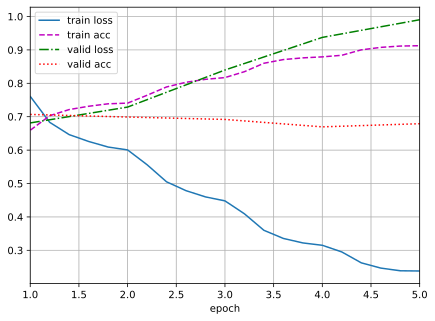

In [ ]:
net = SingleTowerBGE(model_name,cache_dir,args.num_class).to(devices[0])
train_transformer(net,
                  train_iter,
                  dev_iter,
                  args.num_epochs,
                  args.optimizer,
                  args.lr,
                  args.weight_decay,
                  args.num_warmup_steps,
                  devices,
                  task_name)

In [ ]:
test(net,test_iter,None,device = devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, None, device=devices[0])

0it [00:00, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
79it [00:09,  7.93it/s]


test on final epoch -- acc: 67.60, f1-macro: 59.46
test on /content/drive/MyDrive/CS5242/ckpt/SingleTowerBGE-epoch0-val_acc0.71.pt -- acc: 70.20, f1-macro: 55.78


### 5.10 <a name='5.8'></a> Dual Tower Relevance Modeling with BGE
[Back to Table of Contents](#top)

<div style="display: flex; justify-content: center;">
  <img src="img/dual_tower_bge.jpg" alt="dual_tower_bge" width="500"/>
</div>

Dual Tower Relevance Modeling with BGE refers to a design where the query and document are processed separately through two independent encoders, typically based on transformer architectures. Each encoder generates a dense embedding for its respective input (query or document). The relevance score is then computed based on the similarity (e.g., dot product or cosine similarity) between the two embeddings.

Compared to single-tower models, the dual-tower approach enables much faster inference because query and document embeddings can be pre-computed and stored for efficient retrieval. Although dual-tower models might sacrifice some fine-grained interaction between the query and document, they are highly scalable and particularly effective for large-scale retrieval tasks.

In [ ]:
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "BAAI/bge-small-zh-v1.5" ; cache_dir = "/content/drive/MyDrive/CS5242/bge-small-zh-v1.5"
test_data_name = "test_public.json" ; train_data_name = "train.json"
args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
task_name = "DualTowerBGE"
download_model(model_name,cache_dir)

Total Parameters: 23,953,920, Trainable: 23,953,920
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 512, padding_idx=0)
    (position_embeddings): Embedding(512, 512)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-3): 4 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:45000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:5000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

train_data = DualTowerBGEDataset(model_name, cache_dir,train_examples)
dev_data = DualTowerBGEDataset(model_name, cache_dir,dev_examples)
test_data = DualTowerBGEDataset(model_name, cache_dir,test_examples)

train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

Converting data: 100%|██████████| 5000/5000 [00:02<00:00, 2494.71it/s]


In [ ]:
class DualTowerBGE(nn.Module):
    """ Dual Tower Transformer Encoder """
    def __init__(self, model_name, cache_dir, output_dim):
        super().__init__()
        self.model_name = model_name
        self.cache_dir = cache_dir
        self.query_encoder = AutoModel.from_pretrained(self.model_name, cache_dir=self.cache_dir)
        self.doc_encoder = AutoModel.from_pretrained(self.model_name, cache_dir=self.cache_dir)
        self.d_model = self.query_encoder.config.hidden_size
        self.clf = nn.Sequential(
            nn.Linear(self.d_model * 2, self.d_model),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(self.d_model, output_dim),
        )

    def forward(self, query_input_ids,
                      query_attention_mask,
                      query_token_type_ids,
                      doc_input_ids,
                      doc_attention_mask,
                      doc_token_type_ids,
                      **kwargs):
        '''
        query_inputs: dict, doc_inputs: dict
        Including input_ids, attention_mask, token_type_ids
        '''
        query_inputs = {"input_ids":query_input_ids,
                        "attention_mask":query_attention_mask,
                        "token_type_ids":query_token_type_ids}
        doc_inputs   = {"input_ids":doc_input_ids,
                        "attention_mask":doc_attention_mask,
                        "token_type_ids":doc_token_type_ids}
        query_output = self.query_encoder(**query_inputs).last_hidden_state[:, 0, :]  # [CLS]
        doc_output = self.doc_encoder(**doc_inputs).last_hidden_state[:, 0, :]        # [CLS]
        concat = torch.cat([query_output, doc_output], dim=-1)  # [batch, 2*d_model]
        logits = self.clf(concat)
        return logits

train loss 0.499, train acc 0.796, valid loss 0.864, valid acc 0.663
814.2 examples/sec on [device(type='cuda')]


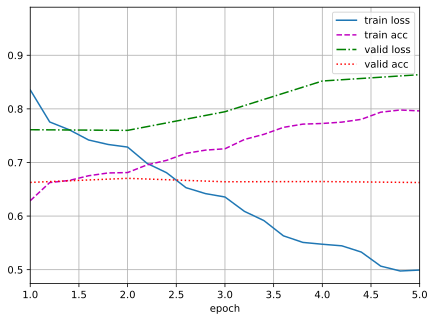

In [ ]:
net = DualTowerBGE(model_name,cache_dir,args.num_class).to(devices[0])
train_transformer(net,
                  train_iter,
                  dev_iter,
                  args.num_epochs,
                  args.optimizer,
                  args.lr,
                  args.weight_decay,
                  args.num_warmup_steps,
                  devices,
                  task_name)

In [ ]:
test(net,test_iter,None,device = devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, None, device=devices[0])

0it [00:00, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
79it [00:02, 34.46it/s]


test on final epoch -- acc: 66.08, f1-macro: 54.36
test on /content/drive/MyDrive/CS5242/ckpt/DualTowerBGE-epoch1-val_acc0.67.pt -- acc: 66.84, f1-macro: 50.86


### 5.11 <a name='5.8'></a> Knowledge Distillation
[Back to Table of Contents](#top)

<div style="display: flex; justify-content: center;">
  <img src="img/knowledge_dis.jpg" alt="knowledge_dis" width="500"/>
</div>


A powerful single-tower model is used as the **teacher** to train a dual-tower **student** through knowledge distillation.

The **single-tower teacher** computes high-quality similarity scores by jointly encoding the query and document.
The **dual-tower student** encodes query and document separately and tries to match the teacher's scores.
The student learns to approximate the teacher’s behavior while maintaining efficiency.

Dual-tower is much faster at inference (suitable for large-scale retrieval).Single-tower provides more accurate supervision thanks to full input interaction.Knowledge Distillation Combine the performance of a strong teacher with the speed of a lightweight student.

**KL divergence loss:**
$$
\mathcal{L}_{\text{KD}} = T^2 \times \sum_{i} p^t_i \log\left( \frac{p^t_i}{p^s_i} \right)
$$

**Total loss combining hard and soft targets:**
$$
\mathcal{L} = \alpha \times \mathcal{L}_{\text{CE}}(y, p^s) + (1 - \alpha) \times \mathcal{L}_{\text{KD}}
$$

**Where:**
- Loss between teacher and student outputs: $ \mathcal{L}_{\text{KD}} $
- Cross-entropy loss between true labels and student predictions: $ \mathcal{L}_{\text{CE}} $
- Teacher soft targets after temperature scaling:  $ p^t $
- Student soft targets after temperature scaling:  $ p^s $
- Temperature parameter: $ T $
- Balance hyperparameter: $ \alpha \in [0, 1] $
- Ground-truth labels: $ y $

In [ ]:
student_model_name = "BAAI/bge-small-zh-v1.5"
student_cache_dir = "/content/drive/MyDrive/CS5242/bge-small-zh-v1.5"

teacher_model_name = "BAAI/bge-base-zh-v1.5"
teacher_cache_dir = "/content/drive/MyDrive/CS5242/bge-base-zh-v1.5"

data_dir = "/content/drive/MyDrive/CS5242/"
test_data_name = "test_public.json"
train_data_name = "train.json"

task_name = "NDDualTowerBGE"
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]

args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'

models = os.listdir("/content/drive/MyDrive/CS5242/ckpt/")
for model in models:
  if "SingleTowerBGE-epoch0-val_acc0.71" in model:
    teacher_ckpt_path = os.path.join("/content/drive/MyDrive/CS5242/ckpt/",model)
    break

In [ ]:
teacher_net = SingleTowerBGE(teacher_model_name, teacher_cache_dir, args.num_class)
teacher_net.load_state_dict(torch.load(teacher_ckpt_path))
teacher_net.to(devices[0])
teacher_net.eval()
for param in teacher_net.parameters():
    param.requires_grad_(False)

student_net = DualTowerBGE(student_model_name, student_cache_dir, args.num_class)
student_net.to(devices[0])

train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:45000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:5000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

student_train_data = DualTowerBGEDataset(student_model_name, student_cache_dir,train_examples)
student_dev_data = DualTowerBGEDataset(student_model_name, student_cache_dir,dev_examples)
student_test_data = DualTowerBGEDataset(student_model_name, student_cache_dir,test_examples)

teacher_train_data = SingleTowerBGEDataset(teacher_model_name, teacher_cache_dir, train_examples)

student_train_iter = DataLoader(dataset=student_train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
student_dev_iter = DataLoader(dataset=student_dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
student_test_iter = DataLoader(dataset=student_test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)
teacher_train_iter = DataLoader(dataset=teacher_train_data,
                       batch_size=args.batch_size,
                       collate_fn = build_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

Converting data: 100%|██████████| 5000/5000 [00:02<00:00, 2456.95it/s]


40000


40000it [00:13, 2864.55it/s]


In [ ]:
def distillation_loss(student_logits, teacher_logits, labels, T=2.0, alpha=0.5):
    soft_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1)
    ) * (T * T)
    hard_loss = F.cross_entropy(student_logits, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

def train_ND_batch(teacher_net, teacher_batch, student_net, student_batch, loss_fn, trainer, devices):
    teacher_net.eval()
    student_net.train()

    teacher_batch = {k: v.to(devices[0]) for k, v in teacher_batch.items()}
    student_batch = {k: v.to(devices[0]) for k, v in student_batch.items()}
    labels = student_batch['label']

    with torch.no_grad():
        teacher_logits = teacher_net(**teacher_batch)

    student_logits = student_net(**student_batch)

    loss = loss_fn(student_logits, teacher_logits, labels)
    trainer.zero_grad()
    loss.backward()
    trainer.step()
    args.learning_rates.append(trainer.param_groups[0]["lr"])

    return loss.item() * labels.shape[0], accuracy(student_logits, labels)

def train_ND(teacher_net,
             student_net,
             teacher_train_iter,
             student_train_iter,
             valid_iter,
             num_epochs,
             optimizer,
             lr,
             wd,
             num_warmup_steps,
             devices,
             task_name):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(student_net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(student_net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(student_net.parameters(), lr=lr, weight_decay=wd)

    model_name = str(net.__class__.__name__)
    scheduler = get_cosine_schedule_with_warmup(trainer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epochs*len(student_train_iter))

    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))

    if args.monitor == 'loss':
        monitor_val = math.inf
    else:
        monitor_val = -math.inf
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, (teacher_batch, student_batch) in enumerate(tqdm(zip(teacher_train_iter, student_train_iter))):
            output = train_ND_batch(teacher_net,
                                    teacher_batch,
                                    student_net,
                                    student_batch,
                                    distillation_loss,
                                    trainer,
                                    devices)
            timer.start()
            labels = student_batch['label']
            scheduler.step()
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2]  , metric[1] / metric[2], None, None))

        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(student_net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if args.monitor == 'loss':
                if valid_loss < monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                    best_model_state = copy.deepcopy(student_net.state_dict())
                    monitor_val = valid_loss
            else:
                if valid_acc > monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_acc{valid_acc :.2f}.pt"
                    best_model_state = copy.deepcopy(student_net.state_dict())
                    monitor_val = valid_acc


    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc  {valid_acc: .3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join(args.pt_path, filename)
    torch.save(best_model_state, args.pt_path)
    animator.save(args.img_path, filename + f"-train_loss{metric[0] / metric[2]:.2f}.png")

train loss 0.363, train acc 0.758, valid loss 0.777, valid acc   0.675
1191269.2 examples/sec on [device(type='cuda')]


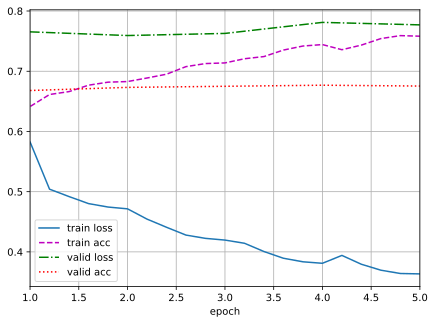

In [ ]:
train_ND(
          teacher_net,
          student_net,
          teacher_train_iter,
          student_train_iter,
          student_dev_iter,
          args.num_epochs,
          args.optimizer,
          args.lr,
          args.weight_decay,
          args.num_warmup_steps,
          devices,
          task_name)

In [ ]:
test(student_net,test_iter,None,device = devices[0])
test_on_checkpoint(student_net, args.pt_path, test_iter, None, device=devices[0])

79it [00:02, 33.70it/s]


test on final epoch -- acc: 67.28, f1-macro: 53.53
test on /content/drive/MyDrive/CS5242/ckpt/NDDualTowerBGE-epoch3-val_acc0.68.pt -- acc: 67.26, f1-macro: 53.68


### 5.12 <a name='5.8'></a> Relevance Modeling with Large Language Model
[Back to Table of Contents](#top)

**Data Preparation Phase**

- **Data Conversion**: Convert the raw query, document, and label data into the input format required by the large model (ChatML conversation format). This step ensures that the data is structured appropriately for model consumption.
- **Tokenization**: Once the data is converted, apply tokenization to split the content into smaller units (tokens). This will generate the following outputs:
  - `input_ids`: Numerical representations of the tokens.
  - `attention_mask`: A mask to indicate which tokens should be attended to by the model.
  - `labels`: The ground truth labels that will be used for training the model, typically indicating the relevance score (0/1/2).

**Model Training Phase**

- **Model Selection**: Use a standard large language model (LLM) which is Qwen-0.5B, that is capable of processing the input query and document pairs.
- **Input Structure**: The model receives a prompt consisting of the concatenated query and document. The model's goal is to predict the relevance score (0/1/2) for each query-document pair.
- **Loss Function**: The training loss is computed using the standard language model loss, which is typically the cross-entropy loss applied to the token predictions. This loss guides the model to improve its predictions by adjusting the weights based on the error in token prediction.

**Model Testing Phase**

- **Input Structure**: During testing, the model is given the query and document as input but does not receive the correct answer label. The model must generate its own relevance score (0/1/2) based on its learned understanding.
- **Generation and Evaluation**: The model's output is compared against the true label to assess its performance. The accuracy of the generated relevance score is measured to evaluate how well the model has learned to predict relevance.

**Example**

  System:

  You are a search engine. You need to judge the relevance between a given user query and a document snippet.
  Score according to the following rules, range 0–2:

  0 – Not relevant;

  1 – Somewhat relevant;

  2 – Relevant.

  User:

  Query is 
  “From the date of filing for divorce, if either party does not agree to the divorce, they may apply to…”

  Document is:

  “According to the Civil Code of the People’s Republic of China, from the date the marriage registration authority receives a divorce registration application, if either party is unwilling to divorce, they may apply to the marriage registration authority for divorce registration.”

  Please give the relevance score (just the number): 
  <span style="color:red;">1 (label)</span>

**The red 1 means that is what we want to predict which is the relevance label.**

In [ ]:
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "Qwen/Qwen2.5-0.5B"
cache_dir = "/content/drive/MyDrive/CS5242/Qwen2.5-0.5B"

test_data_name = "test_public.json"
train_data_name = "train.json"

args = Args()
args.lr = 3e-4
args.num_epochs=3
args.batch_size=8
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
task_name = "Relevance with LLM"
download_model(model_name,cache_dir)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Total Parameters: 494,032,768, Trainable: 494,032,768
Qwen2Model(
  (embed_tokens): Embedding(151936, 896)
  (layers): ModuleList(
    (0-23): 24 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=896, out_features=896, bias=True)
        (k_proj): Linear(in_features=896, out_features=128, bias=True)
        (v_proj): Linear(in_features=896, out_features=128, bias=True)
        (o_proj): Linear(in_features=896, out_features=896, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
        (up_proj): Linear(in_features=896, out_features=4864, bias=False)
        (down_proj): Linear(in_features=4864, out_features=896, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((896,), eps=1e-06)
  (rotary_emb): Qwen2RotaryEmbedding()
)


In [ ]:
class Qwen2LLMDataset(Dataset):
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, cache_dir=cache_dir, trust_remote_code=True
        )
        self.samples = samples
        self.convert_data_to_features()

    def convert_data_to_features(self):
        self.data = []
        system_prompt = \
        """你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。
           请根据以下规则打分，范围 0 到 2：\n
           0-无关；1-一般相关；2-相关。"""
        for sample in tqdm(self.samples, desc="Preparing ChatML prompts"):
            query = sample['query']
            document = sample['title']
            label = str(sample['label'])
            messages = [
                {"role": "system",    "content": system_prompt},
                {"role": "user",      "content":
                    f"查询内容：{query}\n"
                    f"文档片段：{document}\n"
                    "请给出相关性评分（仅填写数字）："
                },
                {"role": "assistant", "content": label}
            ]
            # 先拼 prompt，再 tokenize
            prompt = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False
            )
            encoded = self.tokenizer(
                prompt,
                truncation=False,
                padding=False,
                return_tensors=None
            )
            input_ids = encoded['input_ids'] + [self.tokenizer.eos_token_id]
            attenttiom_mask = encoded['attention_mask'] + [1]
            label_ids = input_ids[-4:]
            labels = [-100] * (len(input_ids) - 4) + label_ids

            self.data.append({
                "input_ids": input_ids,
                "attention_mask":attenttiom_mask,
                "labels": labels
            })

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

def build_qwen2_collate_fn(tokenizer):
    def collate_fn(batch):
        # 把 list-of-dicts 拆成三个 list-of-lists
        input_ids_list     = [torch.tensor(ex["input_ids"],     dtype=torch.long) for ex in batch]
        attention_list     = [torch.tensor(ex["attention_mask"], dtype=torch.long) for ex in batch]
        labels_list        = [torch.tensor(ex["labels"],        dtype=torch.long) for ex in batch]
        from torch.nn.utils.rnn import pad_sequence

        # 手动 pad_sequence
        input_ids_padded      = pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_padded      = pad_sequence(attention_list, batch_first=True, padding_value=0)
        labels_padded         = pad_sequence(labels_list, batch_first=True, padding_value=-100)

        return {
            "input_ids":      input_ids_padded,
            "attention_mask": attention_padded,
            "labels":         labels_padded,
        }
    return collate_fn

class Qwen2LLMTestDataset(Dataset):
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, cache_dir=cache_dir, trust_remote_code=True
        )
        self.samples = samples
        self.convert_data_to_features()

    def convert_data_to_features(self):
        self.data = []
        system_prompt = \
        """你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。
           请根据以下规则打分，范围 0 到 2：\n
           0-无关；1-一般相关；2-相关。"""
        for sample in tqdm(self.samples, desc="Preparing ChatML prompts"):
            query = sample['query']
            document = sample['title']
            label = str(sample['label'])  # e.g. "0","1","2"
            messages = [
                {"role": "system",    "content": system_prompt},
                {"role": "user",      "content":
                    f"查询内容：{query}\n"
                    f"文档片段：{document}\n"
                    "请给出相关性评分（仅填写数字）："
                },
            ]
            # 先拼 prompt，再 tokenize
            prompt = self.tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                tokenize=False
            )
            self.data.append({"prompt":prompt,"label":label})

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

def build_qwen2_test_collate_fn(tokenizer):
    def collate_fn(batch):
        prompts = [sample['prompt'] for sample in batch]
        labels = [item['label'] for item in batch]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(devices[0])
        return {
            "input_ids":      inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "labels":         labels
        }
    return collate_fn

def train_llm_batch(net, batch, optimizer, device):
    net.train()
    optimizer.zero_grad()
    # Move inputs and labels to device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch.get('attention_mask', None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)
    labels = batch['labels'].to(device)

    # Forward pass
    outputs = net(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )
    loss = outputs.loss

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()

    return loss.item()


def train_llm(
    net,
    train_loader,
    valid_loader=None,
    num_epochs=3,
    lr=5e-5,
    wd=0.0,
    num_warmup_steps=0,
    device=None,
    monitor="loss",
    task_name="llm_task",
    output_dir="."
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)
    total_steps = num_epochs * len(train_loader)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=total_steps
    )

    best_metric = float('inf')
    best_state = None
    best_filename = None

    # Training loop
    for epoch in range(1, num_epochs + 1):
        net.train()
        epoch_loss = 0.0
        num_samples = 0

        for batch in tqdm(train_loader):
            loss = train_llm_batch(net, batch, optimizer, device)
            batch_size = batch['input_ids'].size(0)
            epoch_loss += loss * batch_size
            num_samples += batch_size
            scheduler.step()

        train_loss = epoch_loss / num_samples
        print(f"Epoch {epoch}/{num_epochs} - train loss: {train_loss:.4f}")

        # Validation
        if valid_loader is not None:
            net.eval()
            val_loss = 0.0
            val_samples = 0
            with torch.no_grad():
                for batch in valid_loader:
                    # Reuse train_llm_batch for forward w/o optimizer updates
                    batch_loss = train_llm_batch(net, batch, optimizer, device)
                    bs = batch['input_ids'].size(0)
                    val_loss += batch_loss * bs
                    val_samples += bs
            val_loss /= val_samples
            print(f"Epoch {epoch}/{num_epochs} - valid loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_metric:
                best_metric = val_loss
                best_state = copy.deepcopy(net.state_dict())
                best_filename = f"{task_name}-epoch{epoch}-val{val_loss:.4f}.pt"

    # Save the best model if available
    if best_state is not None and best_filename is not None:
        os.makedirs(output_dir, exist_ok=True)
        save_path = os.path.join(output_dir, best_filename)
        torch.save(best_state, save_path)
        print(f"Best model saved to {save_path} (valid loss: {best_metric:.4f})")
    else:
        print("Training completed. No validation improvements to save.")
def test_llm(net,test_iter):
  net.eval()
  gt = []
  with torch.no_grad():
    for batch in test_iter:
      outputs = net.generate(**batch)
      generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
      gt += batch['labels']

In [ ]:
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:45000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:5000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)
labels = [ex["label"] for ex in train_examples]
dist = Counter(labels)
print("Data Information",dist)
train_data = Qwen2LLMDataset(model_name, cache_dir,train_examples)
dev_data = Qwen2LLMDataset(model_name, cache_dir,dev_examples)
test_data = Qwen2LLMTestDataset(model_name, cache_dir,test_examples)

train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_qwen2_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_qwen2_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_qwen2_test_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

Data Information Counter({1: 25126, 0: 9757, 2: 5117})


Preparing ChatML prompts: 100%|██████████| 5000/5000 [00:00<00:00, 20028.04it/s]


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    trust_remote_code=True
)

net = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    torch_dtype="auto",
    trust_remote_code=True,
    device_map="cuda:0"
)

train_llm(
          net,
          train_iter,
          None,
          args.num_epochs,
          args.lr,
          args.weight_decay,
          args.num_warmup_steps,
          devices[0],
          monitor="loss",
          task_name=task_name)

100%|██████████| 5000/5000 [17:45<00:00,  4.69it/s]


Epoch 1/3 - train loss: 0.3569


100%|██████████| 5000/5000 [17:46<00:00,  4.69it/s]


Epoch 2/3 - train loss: 0.2214


100%|██████████| 5000/5000 [17:46<00:00,  4.69it/s]

Epoch 3/3 - train loss: 0.2112
Training completed. No validation improvements to save.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    trust_remote_code=True
)
pred = []
gt = []
for test_batch in test_iter:
  inputs = {"input_ids": test_batch["input_ids"].to(devices[0]),
            "attention_mask": test_batch["attention_mask"].to(devices[0])}
  generated_ids = net.generate(
    **inputs,
    max_new_tokens=30,
    temperature=1,
    top_k= 1,
    top_p =0.9,
    eos_token_id=tokenizer.eos_token_id,
)
  generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs["input_ids"], generated_ids)
]
  generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
  for text in generated_texts:
    pred.append(text)
  gt += test_batch['labels']

In [ ]:
test(student_net,test_iter,None,device = devices[0])
test_on_checkpoint(student_net, args.pt_path, test_iter, None, device=devices[0])

0it [00:00, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
79it [00:09,  7.93it/s]


test on final epoch -- acc: 67.60, f1-macro: 59.46
test on /content/drive/MyDrive/CS5242/ckpt/SingleTowerBGE-epoch0-val_acc0.71.pt -- acc: 70.20, f1-macro: 55.78


##  6. <a name='6'></a>Results
[Back to Table of Contents](#top)

We report the performance of various models on the document relevance classification task across three relevance levels: Poor, Moderately, and Highly relevant. The evaluation metrics include Precision, Recall, and F1-score for each relevance category, along with the macro-averaged results.


<table border="1" cellspacing="0" cellpadding="5">
  <thead>
    <tr>
      <th rowspan="2">Model</th>
      <th colspan="3">Label 0</th>
      <th colspan="3">Label 1</th>
      <th colspan="3">Label 2</th>
      <th colspan="3">Macro Average</th>
    </tr>
    <tr>
      <th>Precision</th><th>Recall</th><th>F1-score</th>
      <th>Precision</th><th>Recall</th><th>F1-score</th>
      <th>Precision</th><th>Recall</th><th>F1-score</th>
      <th>Precision</th><th>Recall</th><th>F1-score</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>MLP</td><td>0.6166</td><td>0.1290</td><td>0.2134</td><td>0.6484</td><td>0.9725</td><td>0.7780</td><td>0.2222</td><td>0.0032</td><td>0.0062</td><td>0.4957</td><td>0.3682</td><td>0.3326</td></tr>
    <tr><td>CNN</td><td>0.8333</td><td>0.0041</td><td>0.0082</td><td>0.6322</td><td>0.9984</td><td>0.7742</td><td>0.2000</td><td>0.0016</td><td>0.0031</td><td>0.5552</td><td>0.3347</td><td>0.2618</td></tr>
    <tr><td>Transformer</td><td>0.5637</td><td>0.3366</td><td>0.4215</td><td>0.6912</td><td>0.8665</td><td>0.7689</td><td>0.4717</td><td>0.2373</td><td>0.3158</td><td>0.5755</td><td>0.4801</td><td>0.5021</td></tr>
    <tr><td>BGE+Transformer</td><td>0.7020</td><td>0.4326</td><td>0.5353</td><td>0.7245</td><td>0.8724</td><td>0.7916</td><td>0.4900</td><td>0.3497</td><td>0.4081</td><td>0.6388</td><td>0.5516</td><td>0.5784</td></tr>
    <tr><td>BERT(Single)</td><td>0.7227</td><td>0.5906</td><td>0.6500</td><td>0.7780</td><td>0.8531</td><td>0.8138</td><td>0.5383</td><td>0.4668</td><td>0.5000</td><td>0.6797</td><td>0.6368</td><td>0.6546</td></tr>
    <tr><td>BERT(Double)</td><td>0.6518</td><td>0.4582</td><td>0.5381</td><td>0.7389</td><td>0.8446</td><td>0.7882</td><td>0.4842</td><td>0.4130</td><td>0.4458</td><td>0.6249</td><td>0.5719</td><td>0.5907</td></tr>
    <tr><td>RNN(Single)</td><td>0.5082</td><td>0.4119</td><td>0.4550</td><td>0.6938</td><td>0.8297</td><td>0.7557</td><td>0.4174</td><td>0.1598</td><td>0.2311</td><td>0.5398</td><td>0.4671</td><td>0.4806</td></tr>
    <tr><td>RNN(Double)</td><td>0.5679</td><td>0.3598</td><td>0.4405</td><td>0.6939</td><td>0.8563</td><td>0.7666</td><td>0.4196</td><td>0.2231</td><td>0.2931</td><td>0.5605</td><td>0.4797</td><td>0.4995</td></tr>
    <tr><td>LSTM(Single)</td><td>0.5357</td><td>0.4467</td><td>0.4871</td><td>0.7185</td><td>0.8177</td><td>0.7649</td><td>0.4887</td><td>0.3070</td><td>0.3771</td><td>0.5810</td><td>0.5238</td><td>0.5430</td></tr>
    <tr><td>LSTM(Double)</td><td>0.5707</td><td>0.3937</td><td>0.4770</td><td>0.7075</td><td>0.8433</td><td>0.7684</td><td>0.4680</td><td>0.2896</td><td>0.3578</td><td>0.5815</td><td>0.5089</td><td>0.5307</td></tr>
    <tr><td>GRU(Single)</td><td>0.5445</td><td>0.4351</td><td>0.4837</td><td>0.7197</td><td>0.8192</td><td>0.7662</td><td>0.4703</td><td>0.3259</td><td>0.3850</td><td>0.5782</td><td>0.5268</td><td>0.5450</td></tr>
    <tr><td>GRU(Double)</td><td>0.5727</td><td>0.4202</td><td>0.4847</td><td>0.7158</td><td>0.8370</td><td>0.7716</td><td>0.4821</td><td>0.3196</td><td>0.3844</td><td>0.5902</td><td>0.5256</td><td>0.5459</td></tr>
  </tbody>
</table>



Among all models, **BERT (Single)** achieved the highest overall macro-averaged F1-score (0.6546), indicating its superior capability in handling document relevance classification tasks. This strong performance can be attributed to BERT's pre-trained contextual embeddings, which enable it to capture complex semantic relationships within the text, particularly benefiting "Moderately relevant" and "Highly relevant" categories. On the other hand, one of pre-train task of BERT is **"Next Sentence Prediction"**, which is a binary classification task that aims to predict whether the two sentences following each other are consecutive or not. This task is similiar to the "Relevance" task in our dataset.

On the other hand, **MLP** and **CNN** performed relatively poorly, especially on "Highly relevant" instances, where their F1-scores are extremely low (0.0062 and 0.0031, respectively). This could be because simple MLP and CNN architectures lack the sequential modeling ability required to understand long document structures and fine-grained semantic differences. Specifically, CNNs tend to focus on local patterns but may struggle to capture the broader contextual information necessary for relevance prediction in lengthy documents.

**Transformer** and **BGE+Transformer** models achieved better results than simple RNN or CNN models, showing the advantage of self-attention mechanisms in capturing global dependencies. Notably, integrating BGE with Transformer slightly improved the overall performance, suggesting that additional guidance from a pre-trained backbone enhances the model's robustness.

Recurrent models (RNN, LSTM, GRU) with double-layer architectures slightly outperformed their single-layer counterparts, reflecting the importance of deeper modeling for complex sequence understanding. However, compared to Transformer-based models, their gains were still limited, possibly due to vanishing gradient issues or less effective long-range dependency modeling.


##  7. <a name='7'></a>Conclusion & Future Development
[Back to Table of Contents](#top)

In this project, we systematically explored the effectiveness of various deep learning architectures for query-document relevance prediction on the QBQTC dataset. Our experiments covered a range of models, including traditional RNN-based methods (RNN, LSTM, GRU), Transformer architectures, and BERT variants.

From the evaluation results, several key conclusions can be drawn:

BERT-based models demonstrated the best overall performance, with the BERT (Single) model achieving the highest Macro Average F1-score (0.6546). This highlights the advantage of using pretrained contextual embeddings and deep bidirectional representations in relevance prediction tasks.
Transformer and BGE+Transformer models also performed competitively, outperforming traditional RNN-based models. The self-attention mechanism effectively captures long-range dependencies, which is crucial in matching queries and document titles.
RNN, LSTM, and GRU models showed moderate performance. Although GRU and LSTM models achieved relatively higher F1-scores among the RNN variants, they still lagged behind Transformer-based methods. This could be attributed to their limited ability to model complex interactions over long sequences compared to attention-based architectures.
Simple models like MLP and CNN performed poorly, with the CNN model achieving the lowest Macro Average F1-score (0.2618). The limited expressiveness and inability to capture intricate semantic relationships between queries and documents likely contributed to their subpar performance.
Several possible factors influenced these outcomes:

Pretrained language models like BERT bring strong generalization capabilities from large corpora, providing a significant head start over models trained from scratch.
Attention mechanisms, as used in Transformers, allow models to selectively focus on important parts of the input, which is especially important for short but semantically rich query-document pairs.
Traditional RNNs, despite their sequential modeling strength, struggle with long-term dependencies and are less effective at highlighting the most relevant information for retrieval tasks.
In summary, Transformer-based and pretrained models clearly offer substantial advantages for query-document relevance prediction in web search scenarios. Future work could explore larger model variants, domain-specific pretraining, or incorporating additional signals like authority and timeliness to further enhance retrieval performance.